# Solving the Brachistochrone problem via PTR SCP

 - __PTR__ $\rightarrow$ **P**enalized **T**rust **R**egion
 - __SCP__ $\rightarrow$ **S**equential **C**onvex **P**rogramming

## Analytical solution

(Cycloid)

### Position

<a href="https://www.ijpam.eu/contents/2013-82-3/8/8.pdf">(Reference)</a>

$
\begin{aligned}
&x=R(\theta - \sin \theta) \\
&y=-R(1 - \cos \theta)
\end{aligned}
$

### Velocity

$
\begin{aligned}
&\dot{x} = \frac{d}{dt} x\left(\tfrac{\theta_{f}}{t_{f}} t\right) = R\left(1 - \cos \tfrac{\theta_{f}}{t_{f}} t\right) \frac{\theta_{f}}{t_{f}} \\
&\dot{y} = \frac{d}{dt} y\left(\tfrac{\theta_{f}}{t_{f}} t\right) = -R\left(\sin \tfrac{\theta_{f}}{t_{f}} t\right) \frac{\theta_{f}}{t_{f}} 
\end{aligned}
$

### Acceleration

$
\begin{aligned}
&\ddot{x} = \frac{d}{dt} \dot{x}\left(\tfrac{\theta_{f}}{t_{f}} t\right) = R\left(\sin \tfrac{\theta_{f}}{t_{f}} t\right) \left(\frac{\theta_{f}}{t_{f}}\right)^{2} \\
&\ddot{y} = \frac{d}{dt} \dot{y}\left(\tfrac{\theta_{f}}{t_{f}} t\right) = -R\left(\cos \tfrac{\theta_{f}}{t_{f}} t\right) \left(\frac{\theta_{f}}{t_{f}}\right)^{2}
\end{aligned}
$

## Optimal control problem formulation

(Nonconvex)

$
\begin{aligned}
\min _{u,\ t_{f}} & \quad t_{f} \\
\text { s.t. } & \quad \dot{r} = v, \\
& \quad \dot{v} = u + g, \\
& \quad \color{#db6245}{u^{\top} v = 0}, \\
& \quad r(0) = r_{0},\quad r(t_{f}) = r_{f}, \\
& \quad v(0) = 0,\quad v(t_{f}) = \text{free}
\end{aligned}
$

The reaction-acceleration constraints shown in $\color{#db6245}{\text{red}}$ are nonconvex.

## Discretized convex subproblem

(ZOH on control; reaction-acceleration constraints linearized)

$
\begin{aligned}
\min _{\sigma;\; u_{k} \text{ and } \nu_{k}\ \forall k\; \in\; [0,\; N-2];\\ \quad\ \ \ \eta_{k}\ \forall k\; \in\; [0,\; N-1]} & \quad w_{t_{f}}\,\sigma + w_{\text{vb}} \sum_{k=0}^{N-2} \|\nu_{k}\|_{1} + w_{\text{tr}} \sum_{k=0}^{N-1} \eta_{k} \\
\text { s.t. } & \quad x_{k+1}=A_{\mid k} x_{k}+B_{\mid k} u_{k}+\Sigma_{\mid k} \sigma+z_{\mid k}, & \quad 0 \leq k \leq N-2 \\
& \color{#009670}{\quad \bar{u}_{k}^{\top} \bar{v}_{k} + \bar{v}_{k}^{\top} (u_{k} - \bar{u}_{k}) + \bar{u}_{k}^{\top} (v_{k} - \bar{v}_{k}) + \nu_{k} = 0}, & \quad 0 \leq k \leq N-2\\
& \quad \|x_{k}-\bar{x}_{k}\|_{2} + \|u_{k}-\bar{u}_{k}\|_{2} + \|\sigma-\bar{\sigma}\|_{2} \leq \eta_{k}, & \quad 0 \leq k \leq N-2\\
& \quad \|x_{N-1}-\bar{x}_{N-1}\|_{2} + \|\sigma-\bar{\sigma}\|_{2} \leq \eta_{N-1}, \\
& \quad \sigma \geq t_{f_{\text{min}}}, \\
& \quad r(0) = r_{0},\quad r(\sigma) = r_{f}, \\
& \quad v(0) = 0,\quad v(\sigma) = \text{free}
\end{aligned}
$

where,

$\qquad\ \ \ x = [r, v]^{\top}$ and $\bar{x} = [\bar{r}, \bar{v}]^{\top}$;

$\qquad\ \ \ \bar{x}$, $\bar{u}$, and $\bar{\sigma}$ are the reference states, controls, and time-dilation factor, respectively, from the previous SCP iteration.

The constraints shown in $\color{#009670}{\text{green}}$ are the linearized reaction-acceleration constraints.

## Analytical solution

In [1]:
from params import *
import cvxpy as cp
import time
from scipy.optimize import minimize_scalar, newton
from scipy.integrate import odeint, cumtrapz
from scipy.interpolate import interp1d
import mosek

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
# https://scipython.com/blog/the-brachistochrone-problem/

def cycloid(xf, yf, N):
    """Return the path of Brachistochrone curve from (0,0) to (xf, yf).

    The Brachistochrone curve is the path down which a bead will fall without
    friction between two points in the least time (an arc of a cycloid).
    It is returned as an array of N values of (x, y) between (0, 0) and (xf, yf).

    """

    # Find theta_final from (xf, yf) numerically (by Newton-Raphson)
    def f(theta):
        return yf/xf - (np.cos(theta) - 1)/(theta - np.sin(theta))
    theta_final = newton(f, np.pi/2)

    # Radius of circle generating the cycloid
    R = yf / (np.cos(theta_final) - 1)
    
    # Time of travel
    T = theta_final * np.sqrt(R / abs(G))

    theta = np.linspace(0, theta_final, N)
    
    # Position
    x = R * (theta - np.sin(theta))
    y = R * (np.cos(theta) - 1)
    r = np.vstack((x, y))
    
    # Velocity
    vx = R * (1 - np.cos(theta)) * theta_final/T
    vy = R * (-np.sin(theta)) * theta_final/T
    v = np.vstack((vx, vy))
    
    # Acceleration
    ux = R * np.sin(theta) * (theta_final/T)**2
    uy = R * (-np.cos(theta)) * (theta_final/T)**2
    
    # Reaction-acceleration
    u = np.vstack((ux, uy)) - np.c_[g]
    
    print('T(cycloid) = {:.3f}'.format(T))
    return r, v, u, T

In [4]:
##########################
### Nonlinear dynamics ###
##########################

def controls(t, tf, u, kind):
    if kind == 'zero':
        N = u.shape[1]+1
        dt = tf/(N-1)
        control_times = np.linspace(0, tf-dt, u.shape[1])
    elif kind == 'linear':
        control_times = np.linspace(0, tf, u.shape[1])
    return np.vstack(([interp1d(control_times, ui, kind, fill_value="extrapolate")(t) for ui in [u[0], u[1]]]))

def nonlinear_dynamics_rhs(X, t, tf, u, kind):
    U = controls(t, tf, u, kind)
    Xdot = np.vstack((np.c_[X[2:4]], U+np.c_[g]))
    return Xdot.flatten()

def propagate_nonlinear(X_init, dt_integration, tf, u, kind='zero'):
    ts = np.linspace(0, tf, int(tf/dt_integration)+1)
    X = odeint(nonlinear_dynamics_rhs, X_init, ts, args=(tf, u, kind), full_output = 0)
    return X

In [5]:
(r_cyc, v_cyc, u_cyc, t_cyc) = cycloid(rf[0], rf[1], N)

T(cycloid) = 1.440


### Constraint violation checks

In [6]:
np.sqrt(np.mean((la.norm(u_cyc+np.c_[g], axis=0) - la.norm(g))**2)) # ~0

2.267900593509556e-15

In [7]:
max([abs(u_cyc[:, i].T@v_cyc[:, i]) for i in range(N)]) # ~0

2.1316282072803006e-14

In [8]:
##################################
### Nonlinear propagation test ###
##################################

x_init = np.concatenate((r0, v0))

dt_int = 0.001 # numerical integration time-step

x_cyc = propagate_nonlinear(x_init, dt_int, t_cyc, u_cyc, kind='linear')

In [9]:
for i in range(2):
    import matplotlib as mpl
    mpl.rcParams['figure.dpi'] = 600 
    mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']}) ## for Palatino and other serif fonts use: #rc('font',**{'family':'serif','serif':['Palatino'].flatten()})
    mpl.rc('text', usetex=True)
    from cycler import cycler
    # mpl.rcParams['axes.prop_cycle'] = cycler(color='rkgbcmy')
    mpl.rcParams['axes.prop_cycle'] = cycler(color=['tab:red', 'k', 'tab:green', 'tab:blue', 'tab:grey'])
    mpl.rcParams.update({'figure.autolayout': True})
    mpl.rcParams.update({'font.size': 10})
    mpl.rcParams.update({'legend.fontsize': 10})
    mpl.rcParams.update({'xtick.labelsize':10})
    mpl.rcParams.update({'ytick.labelsize':10})
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D, art3d

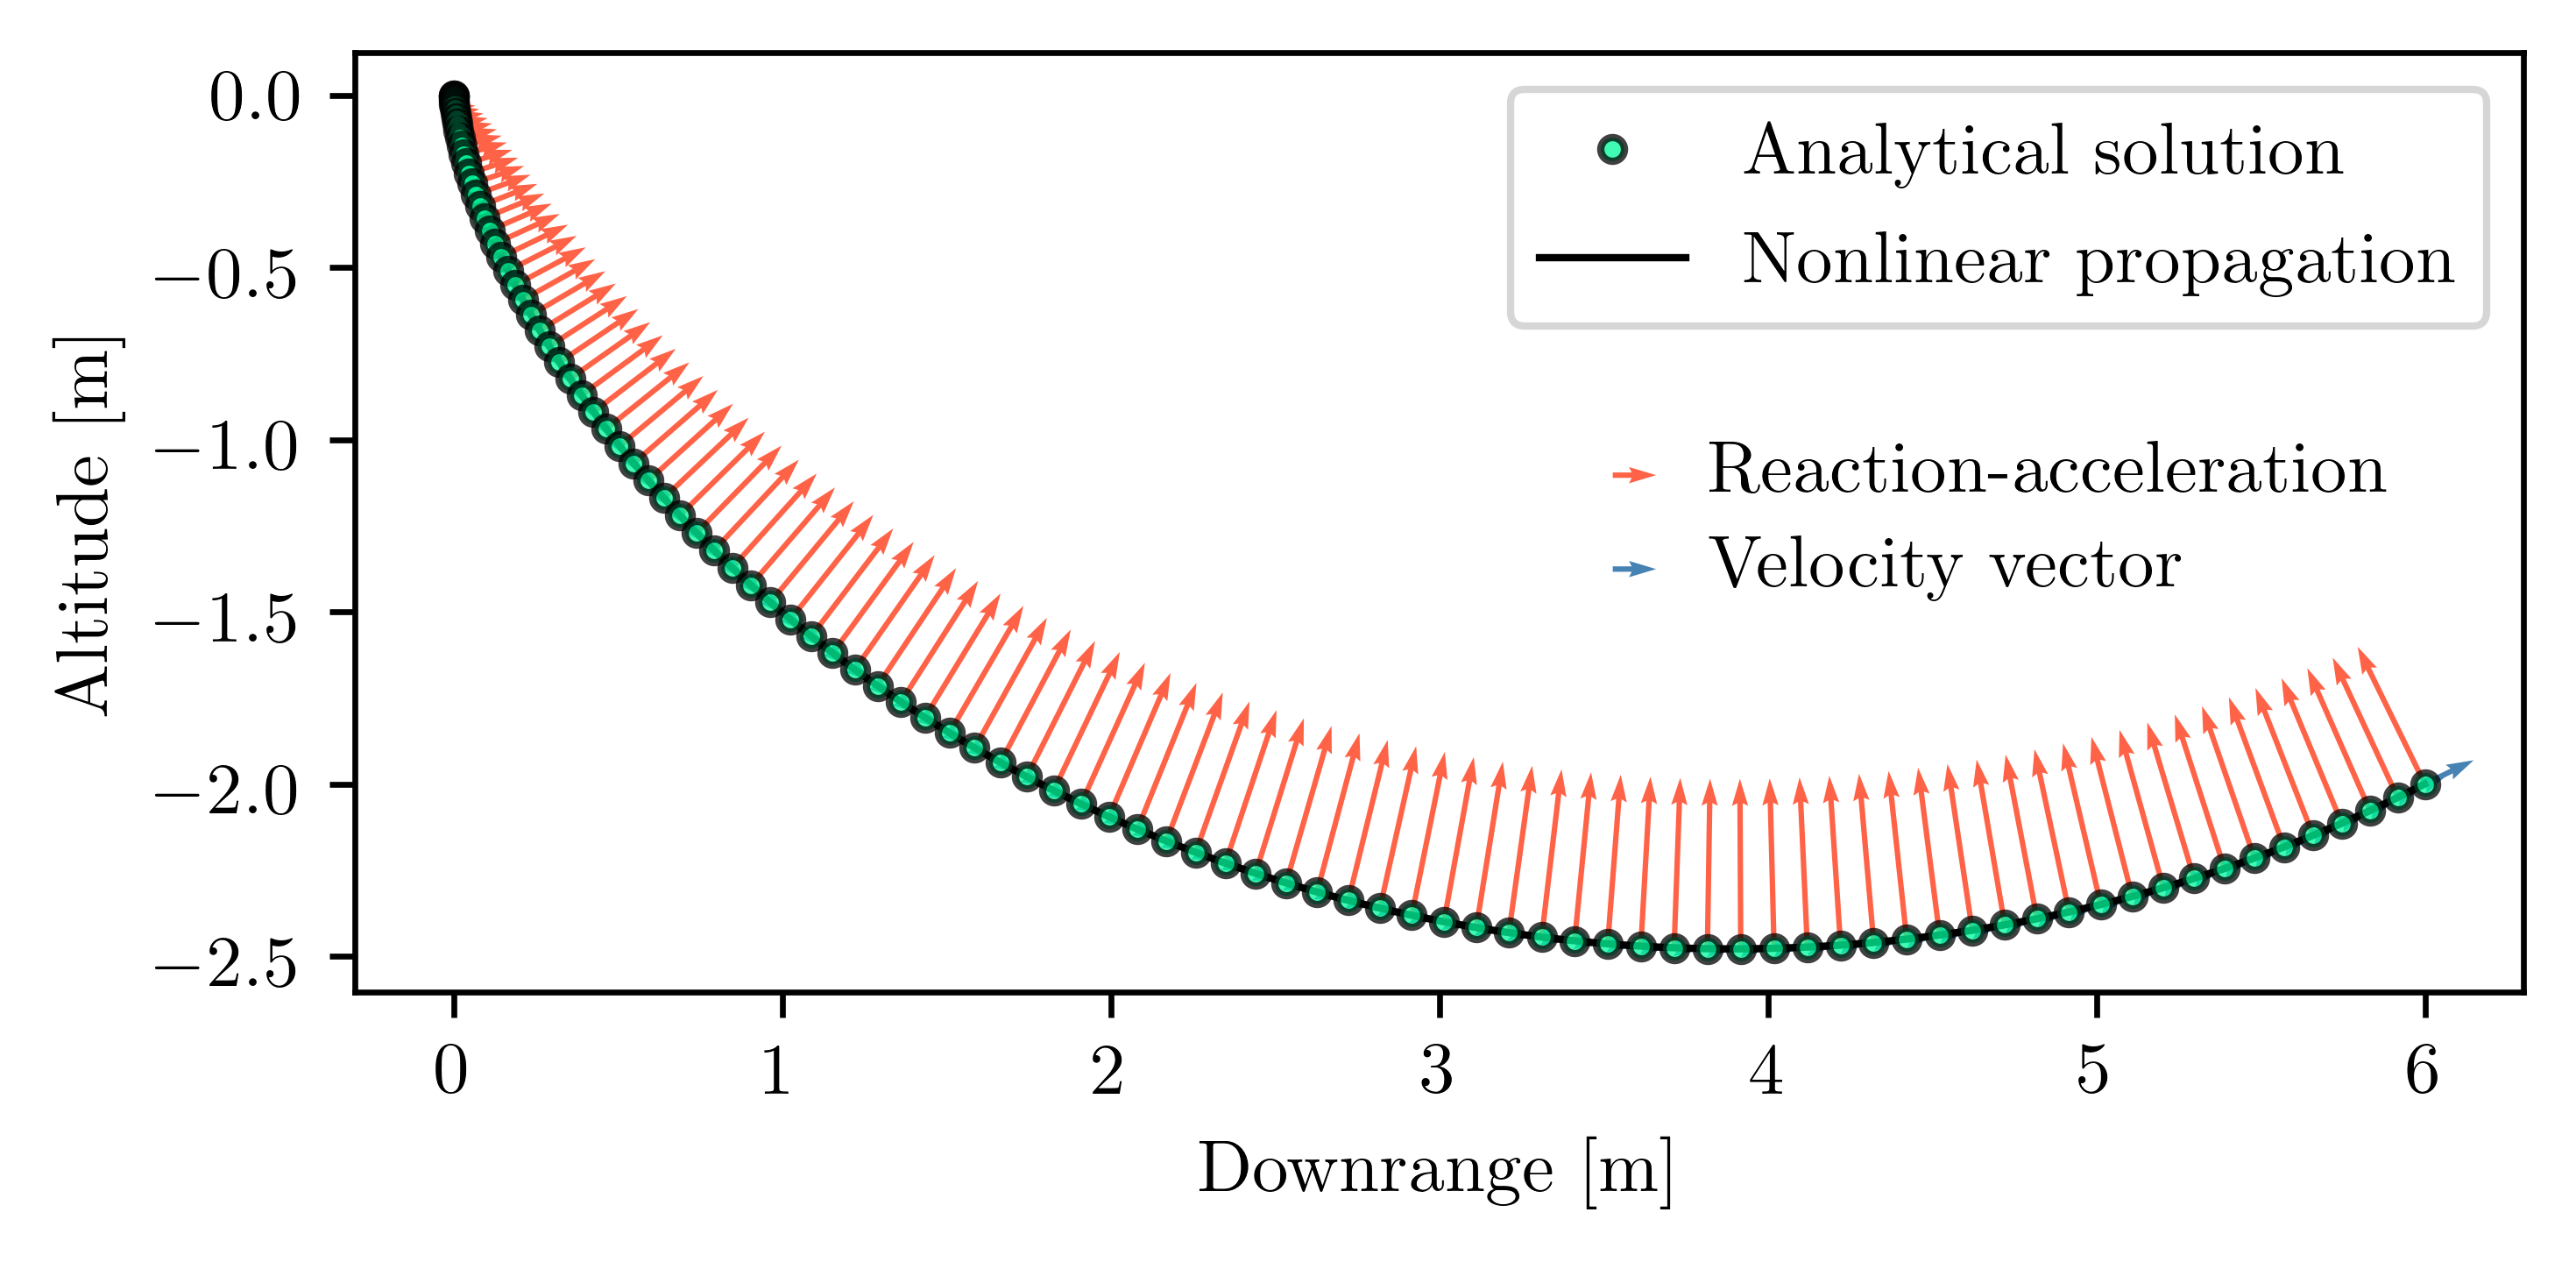

In [10]:
fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = 1
line1 = ax.plot(x_cyc.T[0, :], x_cyc.T[1, :], linewidth=1, color='k', label='Nonlinear propagation')
line2 = ax.plot(r_cyc[0, :], r_cyc[1, :], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='mediumspringgreen', alpha=0.75, label='Analytical solution')
Q1 = ax.quiver(r_cyc[0, :], r_cyc[1, :], u_cyc[0, :], u_cyc[1, :], color='tomato', antialiased=True, width=0.0025, scale=250)
Q2 = ax.quiver(r_cyc[0, :], r_cyc[1, :], v_cyc[0, :], v_cyc[1, :], color='steelblue', antialiased=True, width=0.0025, scale=250)
qk1 = ax.quiverkey(Q1, 0.6, 0.55, 5.0, r'Reaction-acceleration', labelpos='E')
qk2 = ax.quiverkey(Q2, 0.6, 0.45, 5.0, r'Velocity vector', labelpos='E')
plt.xlabel(r'Downrange [m]')
plt.ylabel(r'Altitude [m]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

## Symbolic linearization

<a href="https://arc.aiaa.org/doi/pdf/10.2514/6.2019-0925">(Reference)</a>

In [11]:
import sympy as sm
import sympy.physics.mechanics as me
import numpy as np
me.init_vprinting()

In [12]:
rx, ry, vx, vy, ux, uy, s = me.dynamicsymbols('r_x, r_y, v_x, v_y, u_x, u_y, sigma')
s_bar, rx_bar, ry_bar, vx_bar, vy_bar, ux_bar, uy_bar = sm.symbols('sigmabar, rbar_x, rbar_y, vbar_x, vbar_y, ubar_x, ubar_y')
G_e = sm.symbols('G')

In [13]:
x = sm.Matrix([rx, ry, vx, vy])
u = sm.Matrix([ux, uy])
g = sm.Matrix([0, G_e])

In [14]:
x_bar = sm.Matrix([rx_bar, ry_bar, vx_bar, vy_bar])
u_bar = sm.Matrix([ux_bar, uy_bar])

In [15]:
ref = {rx: rx_bar, ry: ry_bar, vx: vx_bar, vy: vy_bar, ux: ux_bar, uy: uy_bar}
ref_keys = sm.Matrix([ v for v in ref.keys() ])
ref_values = sm.Matrix([ v for v in ref.values() ])

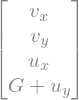

In [16]:
f = sm.Matrix([vx, vy, (u + g)])
f

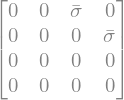

In [17]:
A = s_bar * f.jacobian(x).subs(ref)
A

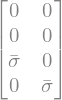

In [18]:
B = s_bar * f.jacobian(u).subs(ref)
B

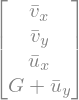

In [19]:
E = f.subs(ref)
E

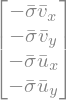

In [20]:
Z = - A * x_bar - B * u_bar
Z

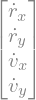

In [21]:
x.diff() # LHS

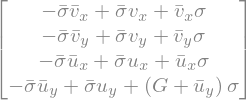

In [22]:
sm.factor(A*x + B*u + s*E + Z) # RHS

## Convex optimization

### Dynamics: linearization and ZOH discretization

In [23]:
from params import *

In [24]:
##############################################
### Linearized dynamics with time-dilation ###
##############################################

def ct_dynamics(ref, i):
    s_ref, r_ref, v_ref, u_ref = ref
    A1 = np.hstack((np.zeros((2, 2)), np.eye(2)))
    A2 = np.zeros((2, 4))
    Ac = s_ref*np.vstack((A1, A2))
    B1 = np.zeros((2, 2))
    B2 = np.eye(2)
    Bc = s_ref*np.vstack((B1, B2))
    Ec = (np.vstack((np.c_[v_ref[:, i]], np.c_[u_ref[:, i]])) + np.vstack((np.c_[np.zeros((2))], np.c_[g])))
    Zc = -Ac@np.vstack((np.c_[r_ref[:, i]], np.c_[v_ref[:, i]]))-Bc@np.c_[u_ref[:, i]]
    return Ac, Bc, Ec, Zc

def dt_dynamics(ref, i, dt):
    Ac, Bc, Ec, Zc = ct_dynamics(ref, i)
    a0, a1 = Ac.shape
    b0, b1 = Bc.shape
    e0, e1 = Ec.shape
    z0, z1 = Zc.shape
    M = la.expm(np.block([[Ac, Bc, Ec, Zc], [np.zeros((b1+e1+z1, a1+b1+e1+z1))]]) * dt)
    Ad = M[0:a1, 0:a1] 
    Bd = M[0:a1, a1:a1+b1]
    Ed = M[0:a1, a1+b1:a1+b1+e1]
    Zd = M[0:a1, a1+b1+e1+z1-1][np.newaxis].T
    return Ad, Bd, Ed, Zd

### Convex subproblem

In [25]:
def cvx_core(ref_traj):
    # Variables
    r = ar@cp.Variable((2, N))
    v = av@cp.Variable((2, N))
    u = au@cp.Variable((2, N-1))
    nu = cp.Variable((N-1))
    nu2 = cp.Variable((N-1))
    eta = cp.Variable((N))
    s = atf*cp.Variable()
    def X(i):
        return cp.vstack([r[0, i], r[1, i], v[0, i], v[1, i]])
    def U(i):
        return cp.vstack([u[0, i], u[1, i]])
    def X_bar(i):
        return cp.vstack([r_bar[0, i], r_bar[1, i], v_bar[0, i], v_bar[1, i]])
    def U_bar(i):
        return cp.vstack([u_bar[0, i], u_bar[1, i]])
    dt = 1/(N-1)
    # Initial condition constraints
    constr  = [r[:, 0] == r0]
    constr += [v[:, 0] == v0]
    constr += [s >= tf_guess] # minimum physically-feasible slide-time
    # Terminal condition constraints
    constr += [r[:, N-1] == rf]
    # Discretized dynamics
    for k in range(0, N-1):
        # Dynamics
        Ad, Bd, Ed, Zd = dt_dynamics(ref_traj, k, dt)
        constr += [X(k+1) == (Ad@X(k) + Bd@U(k) + s*Ed + Zd)]
    # Successive linearization
    s_bar, r_bar, v_bar, u_bar = ref_traj
    for k in range(0, N-2):
        cp.norm(U(k+1)) - cp.norm(U(k)) <= 0.2*dt
    for k in range(0, N-1):
        # Reaction-acceleration normality constraint
        constr += [u_bar[:, k].T @ v_bar[:, k] \
                 + v_bar[:, k].T @ (u[:, k] - u_bar[:, k]) \
                 + u_bar[:, k].T @ (v[:, k] - v_bar[:, k]) \
                 + nu[k] == 0]
        # Trust region
        constr += [cp.norm(X(k) - X_bar(k)) + cp.norm(U(k) - U_bar(k)) + cp.norm(s - s_bar) <= eta[k]]
    constr += [cp.norm(X(N-1) - X_bar(N-1)) + cp.norm(s - s_bar) <= eta[N-1]]
    # Cost function
    cost = w_tf*s + w_vb*cp.norm(nu, 1) + w_tr*cp.abs(cp.sum(eta))
    # Solution
    prob = cp.Problem(cp.Minimize(cost), constr)
    # opt_cost = prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.bi_ignore_max_iter: mosek.onoffkey.on, mosek.iparam.intpnt_scaling: mosek.onoffkey.off, mosek.iparam.presolve_use: mosek.onoffkey.off}) 
    opt_cost = prob.solve(solver=cp.ECOS, max_iters=10000, verbose=False)
    s = s.value
    r = r.value
    v = v.value
    u = u.value
    nu = nu.value
    eta = eta.value
    solver_time = prob.solver_stats.solve_time
    return s, r, v, u, nu, eta, solver_time

## Penalized trust region (PTR) sequential convex programming (SCP)

### Initial guess

In [26]:
#####################################
### Initial guess (straight line) ###
#####################################

# tf_init = tf_guess
# r_init = np.linspace(r0, rf, N).T
# v_init = np.linspace(v0, v_guess, N).T
# u_init = np.linspace(np.zeros(2), u_guess, N-1).T

# ref_traj = (tf_init, r_init, v_init, u_init)

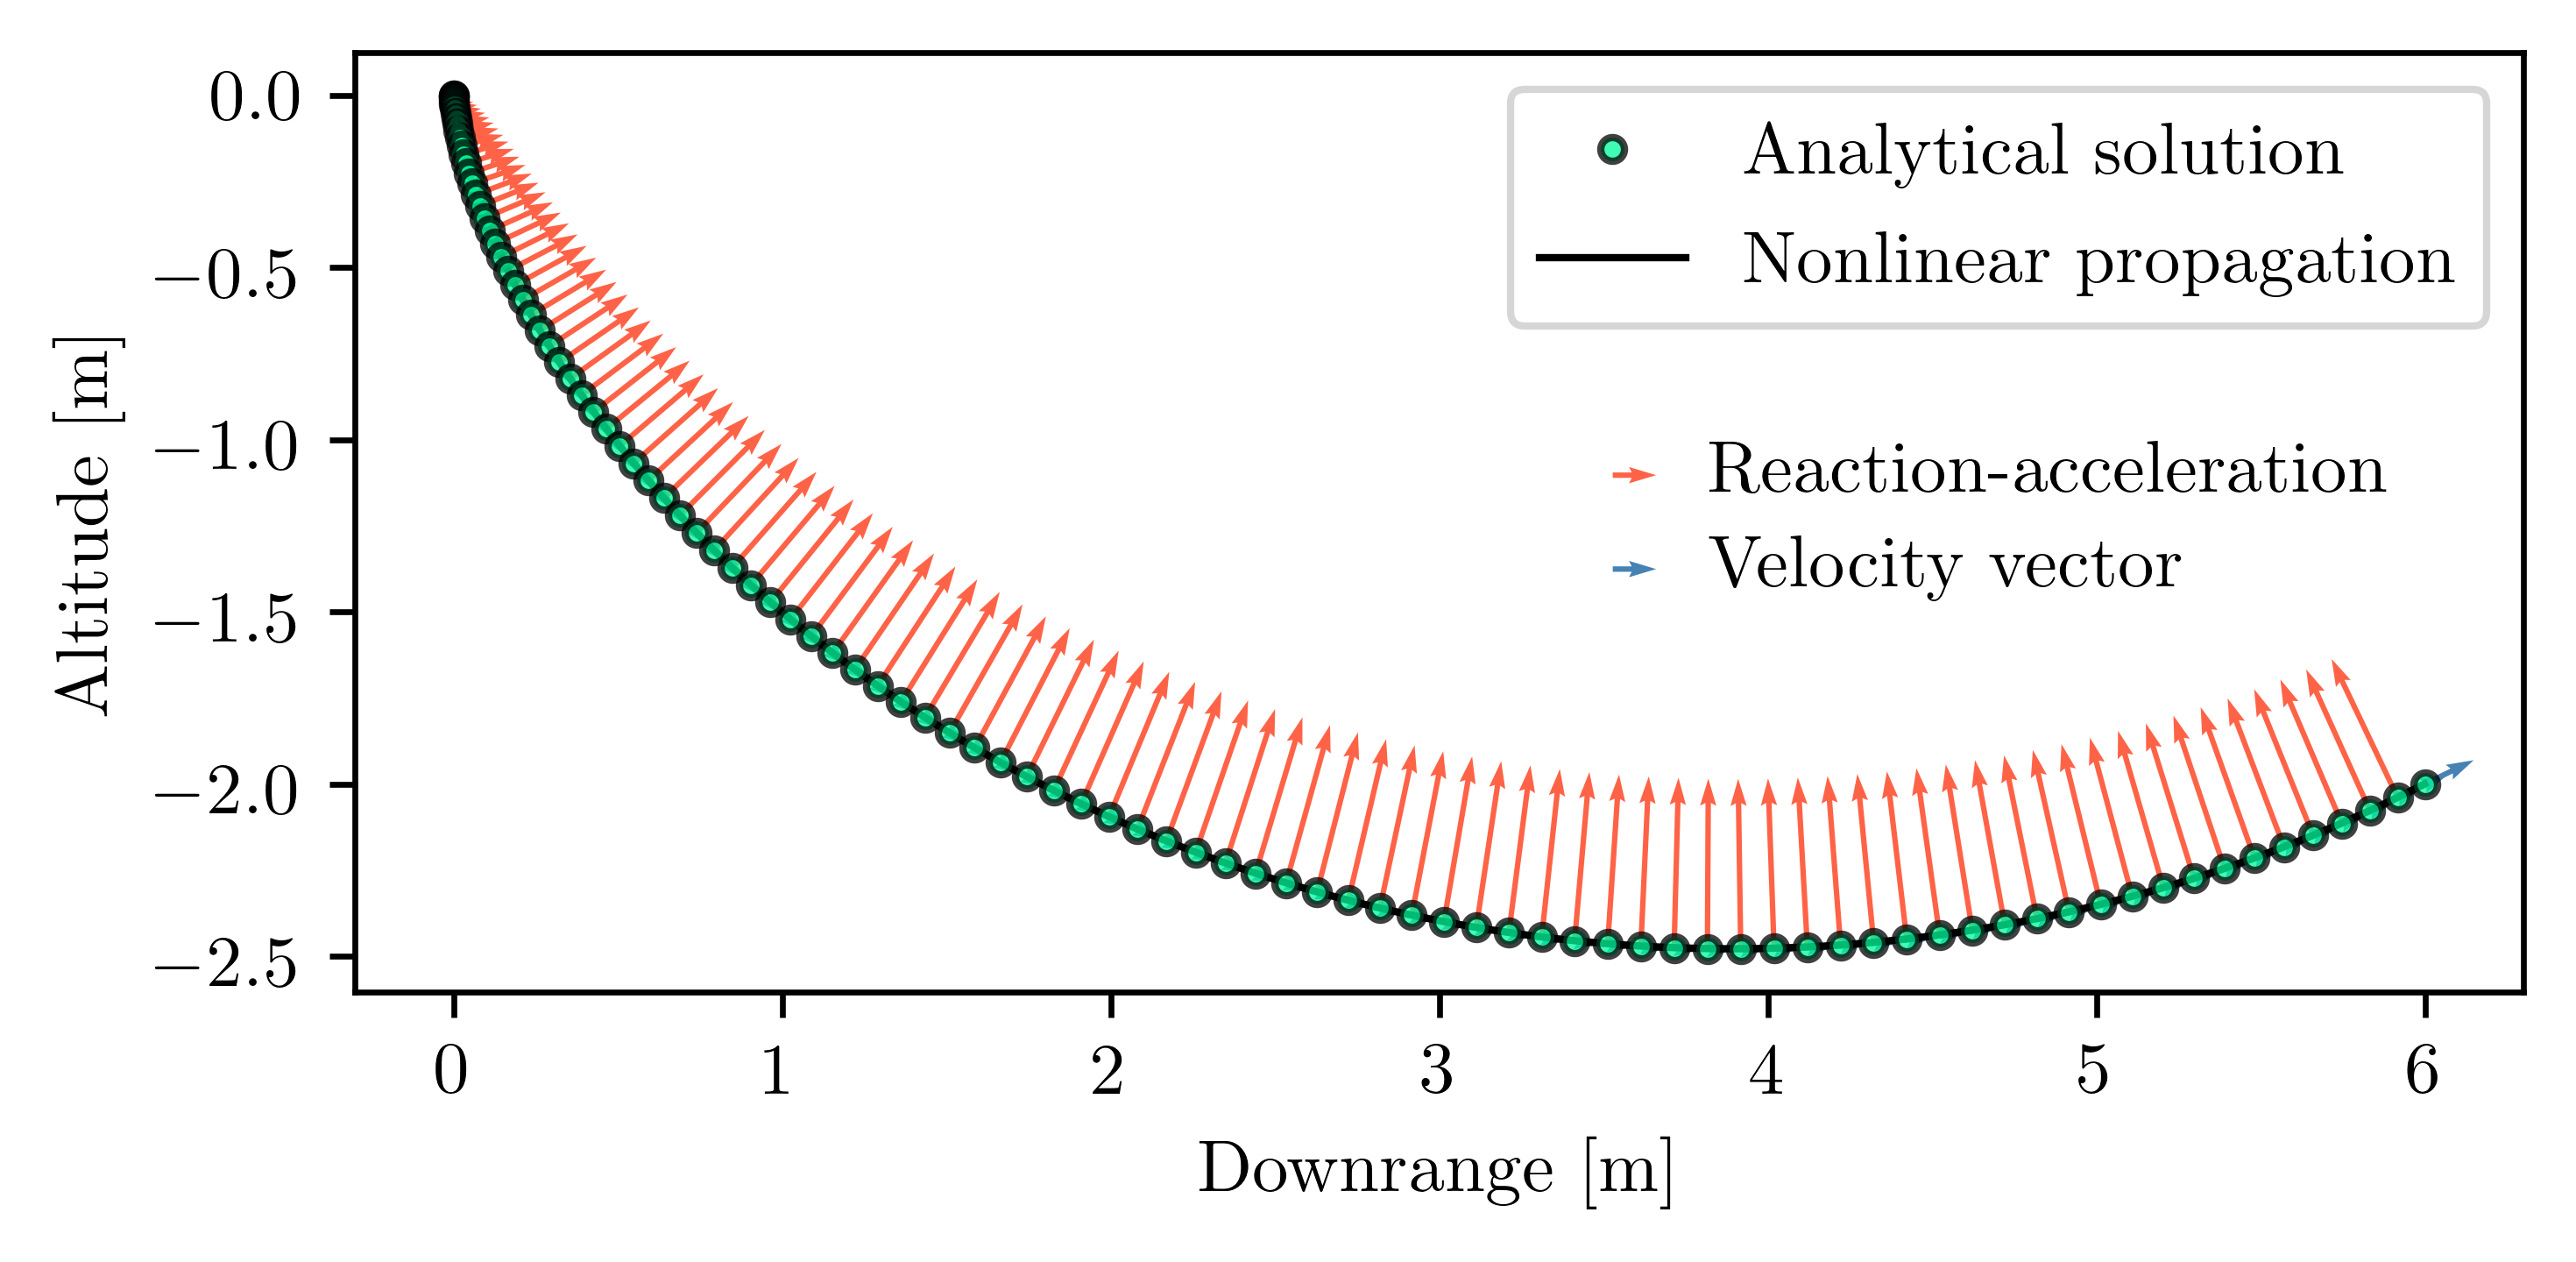

In [27]:
###############################
### Initial guess (cycloid) ###
###############################

tf_init = t_cyc
r_init = r_cyc
v_init = v_cyc

u_cyc_zoh = np.array([(u_cyc[:, i+1] + u_cyc[:, i])/2 for i in range(N-1)]).T # ZOH approximation of the FOH control signal
u_init = u_cyc_zoh 

ref_traj = (tf_init, r_init, v_init, u_init)

########################################
### Validate initial guess (cycloid) ###
########################################

x_cyc_zoh = propagate_nonlinear(x_init, dt_int, t_cyc, u_cyc_zoh, kind='zero')

fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = 1
line1 = ax.plot(x_cyc_zoh.T[0, :], x_cyc_zoh.T[1, :], linewidth=1, color='k', label='Nonlinear propagation')
line2 = ax.plot(r_cyc[0, :], r_cyc[1, :], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='mediumspringgreen', alpha=0.75, label='Analytical solution')
Q1 = ax.quiver(r_cyc[0, :-1], r_cyc[1, :-1], u_cyc_zoh[0, :], u_cyc_zoh[1, :], color='tomato', antialiased=True, width=0.0025, scale=250)
Q2 = ax.quiver(r_cyc.T[:, 0], r_cyc.T[:, 1], v_cyc.T[:, 0], v_cyc.T[:, 1], color='steelblue', antialiased=True, width=0.0025, scale=250)
qk1 = ax.quiverkey(Q1, 0.6, 0.55, 5.0, r'Reaction-acceleration', labelpos='E')
qk2 = ax.quiverkey(Q2, 0.6, 0.45, 5.0, r'Velocity vector', labelpos='E')
plt.xlabel(r'Downrange [m]')
plt.ylabel(r'Altitude [m]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

### SCP loop

In [28]:
################
### SCP loop ###
################

runtime_list = []
solver_time_list = []
for i in range(max_iters):
    start_time = time.time()
    tf_bar, r_bar, v_bar, u_bar, nu, eta, solver_time = cvx_core(ref_traj)
    runtime = time.time() - start_time
    runtime_list += [runtime]
    solver_time_list += [solver_time]
    print("Iteration %s: %.3f s; tf: %.3f s; norm(nu, 1): %.2e; |sum(eta)|: %.2e" % (i+1, runtime, tf_bar, la.norm(nu, 1), abs(np.sum(eta))))
    ref_traj = (tf_bar, r_bar, v_bar, u_bar)
    if (abs(np.sum(eta)) < 1e-4 and la.norm(nu, 1) < 1e-4):
        print("The solution has converged.")
        tf, r, v, u = (tf_bar, r_bar, v_bar, u_bar)
        print("Minimum time: %s s" % tf)
        break
    elif i == max_iters-1:
        tf, r, v, u = (tf_bar, r_bar, v_bar, u_bar)
        print("The maximum number of iterations has been reached.")
        print("Minimum time: %s s" % tf)
        break

print("Total solver time: %s s" % sum(solver_time_list))
print("Total runtime: %s s" % sum(runtime_list))

Iteration 1: 1.708 s; tf: 1.425 s; norm(nu, 1): 2.56e-10; |sum(eta)|: 2.91e+01
Iteration 2: 1.618 s; tf: 1.426 s; norm(nu, 1): 4.24e-08; |sum(eta)|: 6.70e-01
Iteration 3: 3.648 s; tf: 1.426 s; norm(nu, 1): 4.93e-08; |sum(eta)|: 7.78e-05
The solution has converged.
Minimum time: 1.425914148282937 s
Total solver time: 2.148592679 s
Total runtime: 6.973426103591919 s


In [29]:
##################################
### Nonlinear propagation test ###
##################################

x = propagate_nonlinear(x_init, dt_int, tf, u, kind='zero')

## Plots

In [30]:
dt_b = tf/(N-1)
ts = np.linspace(0, tf, int(tf/dt_int)+1) # nonlinear propagation time domain
tss = np.linspace(0, tf, N) # SCP solution state time domain
tsu = np.linspace(0, tf-dt_b, N-1) # SCP solution control time domain

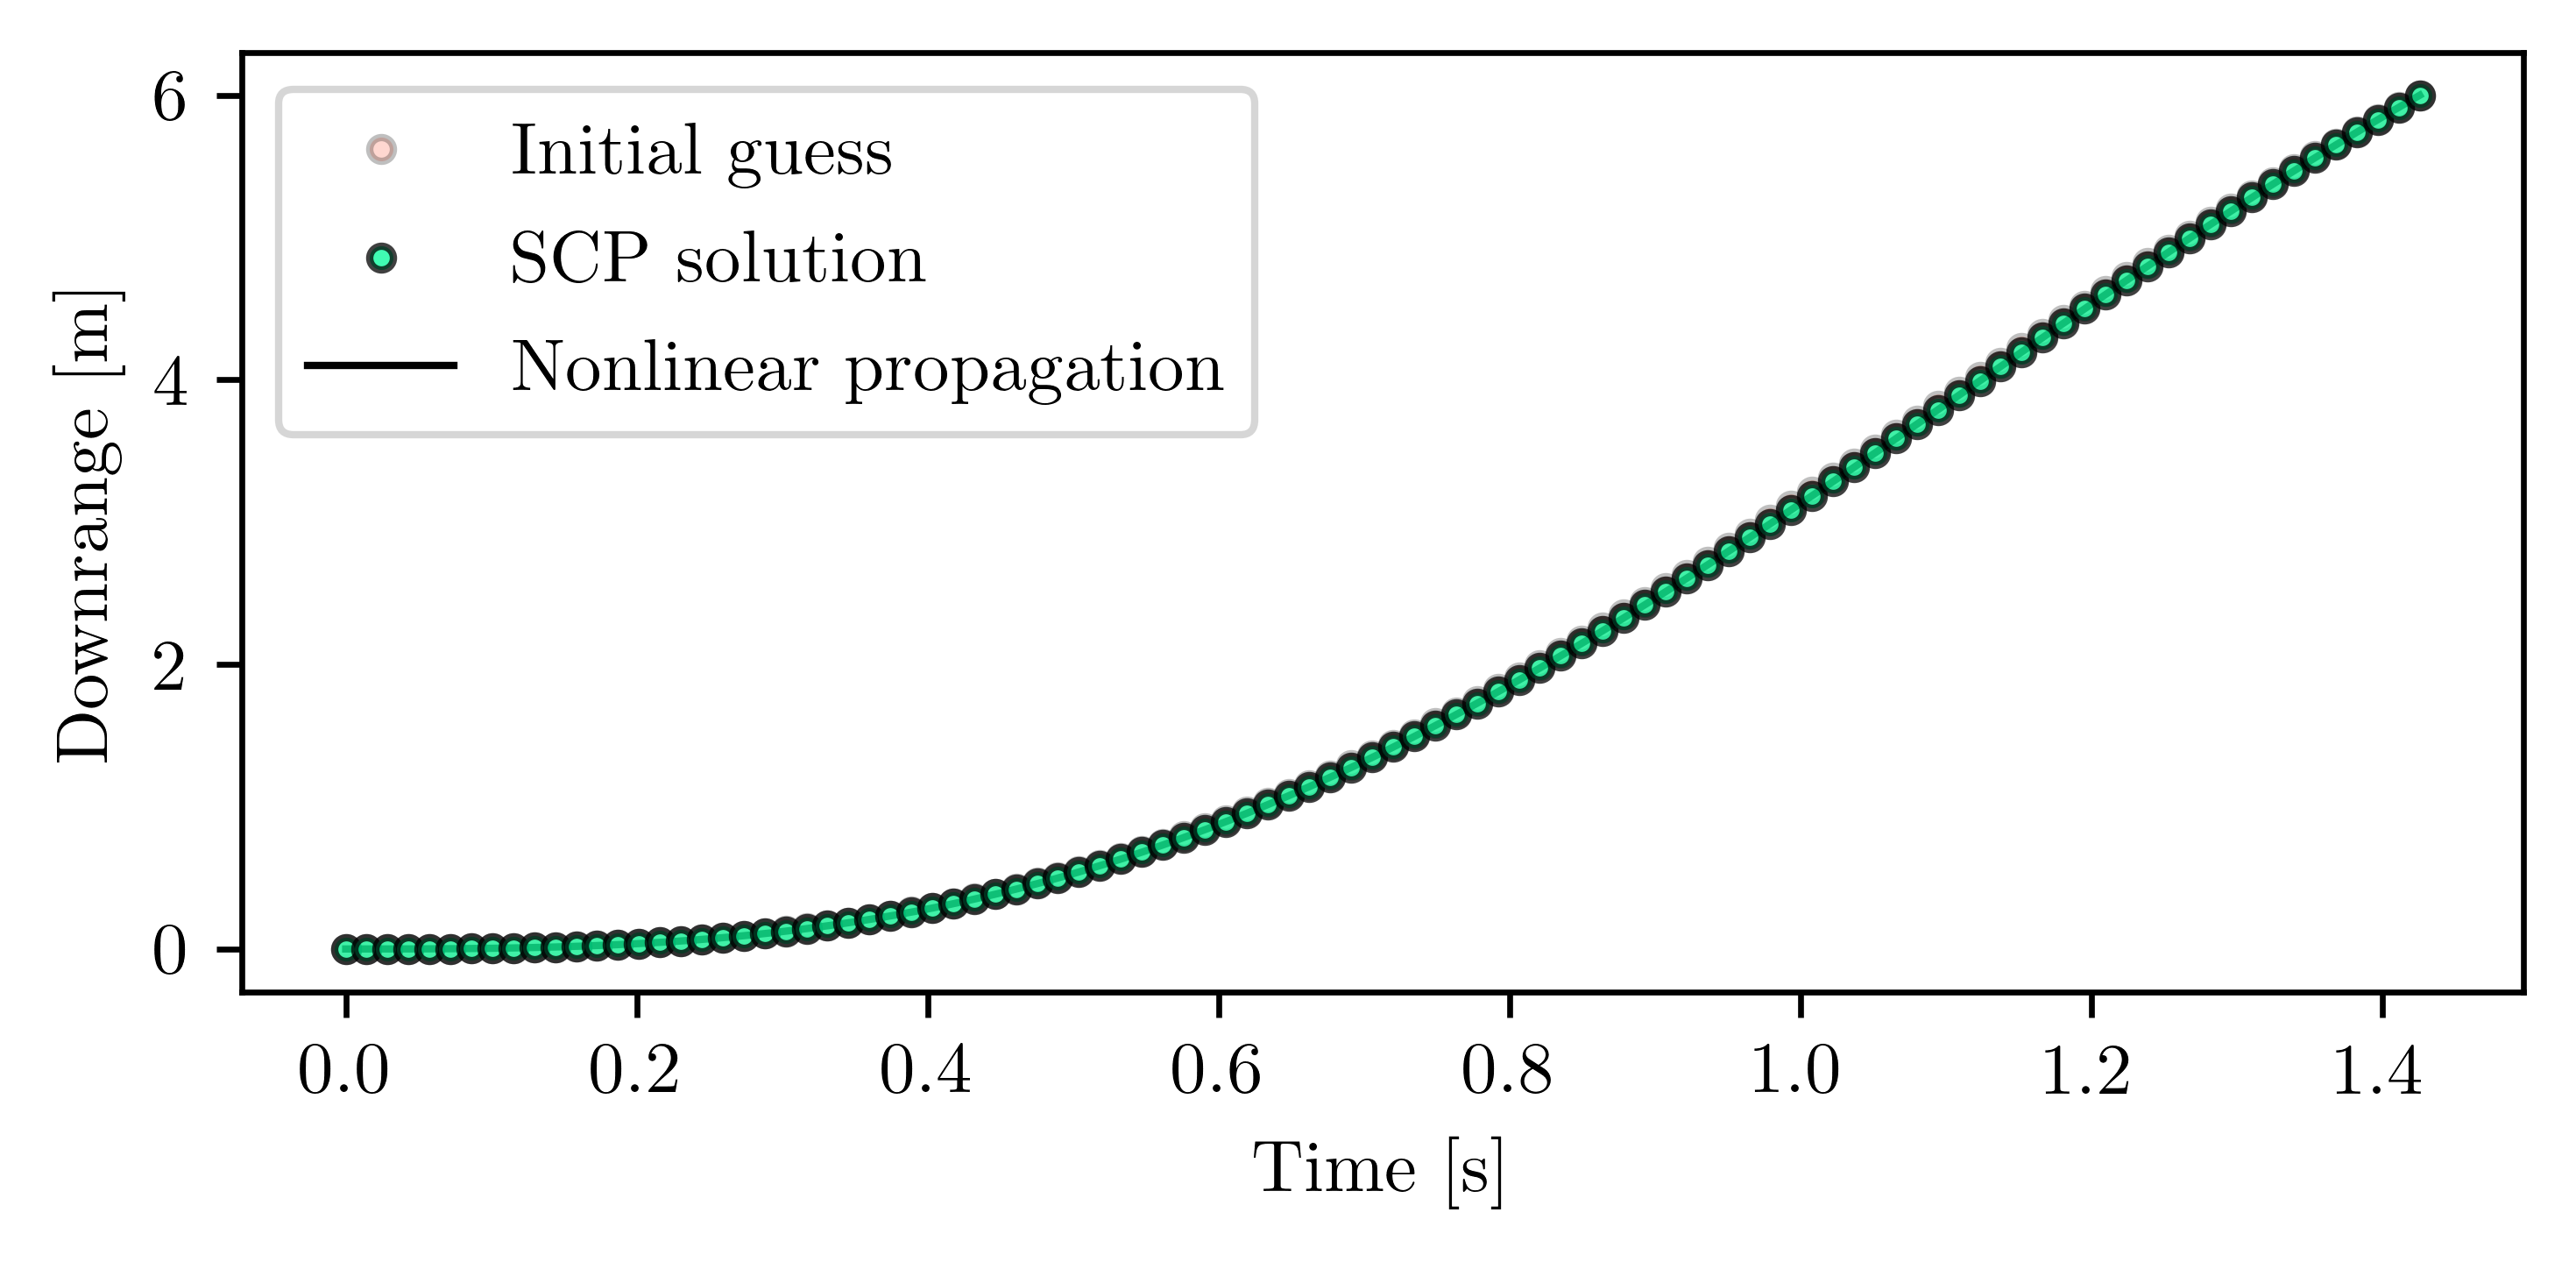

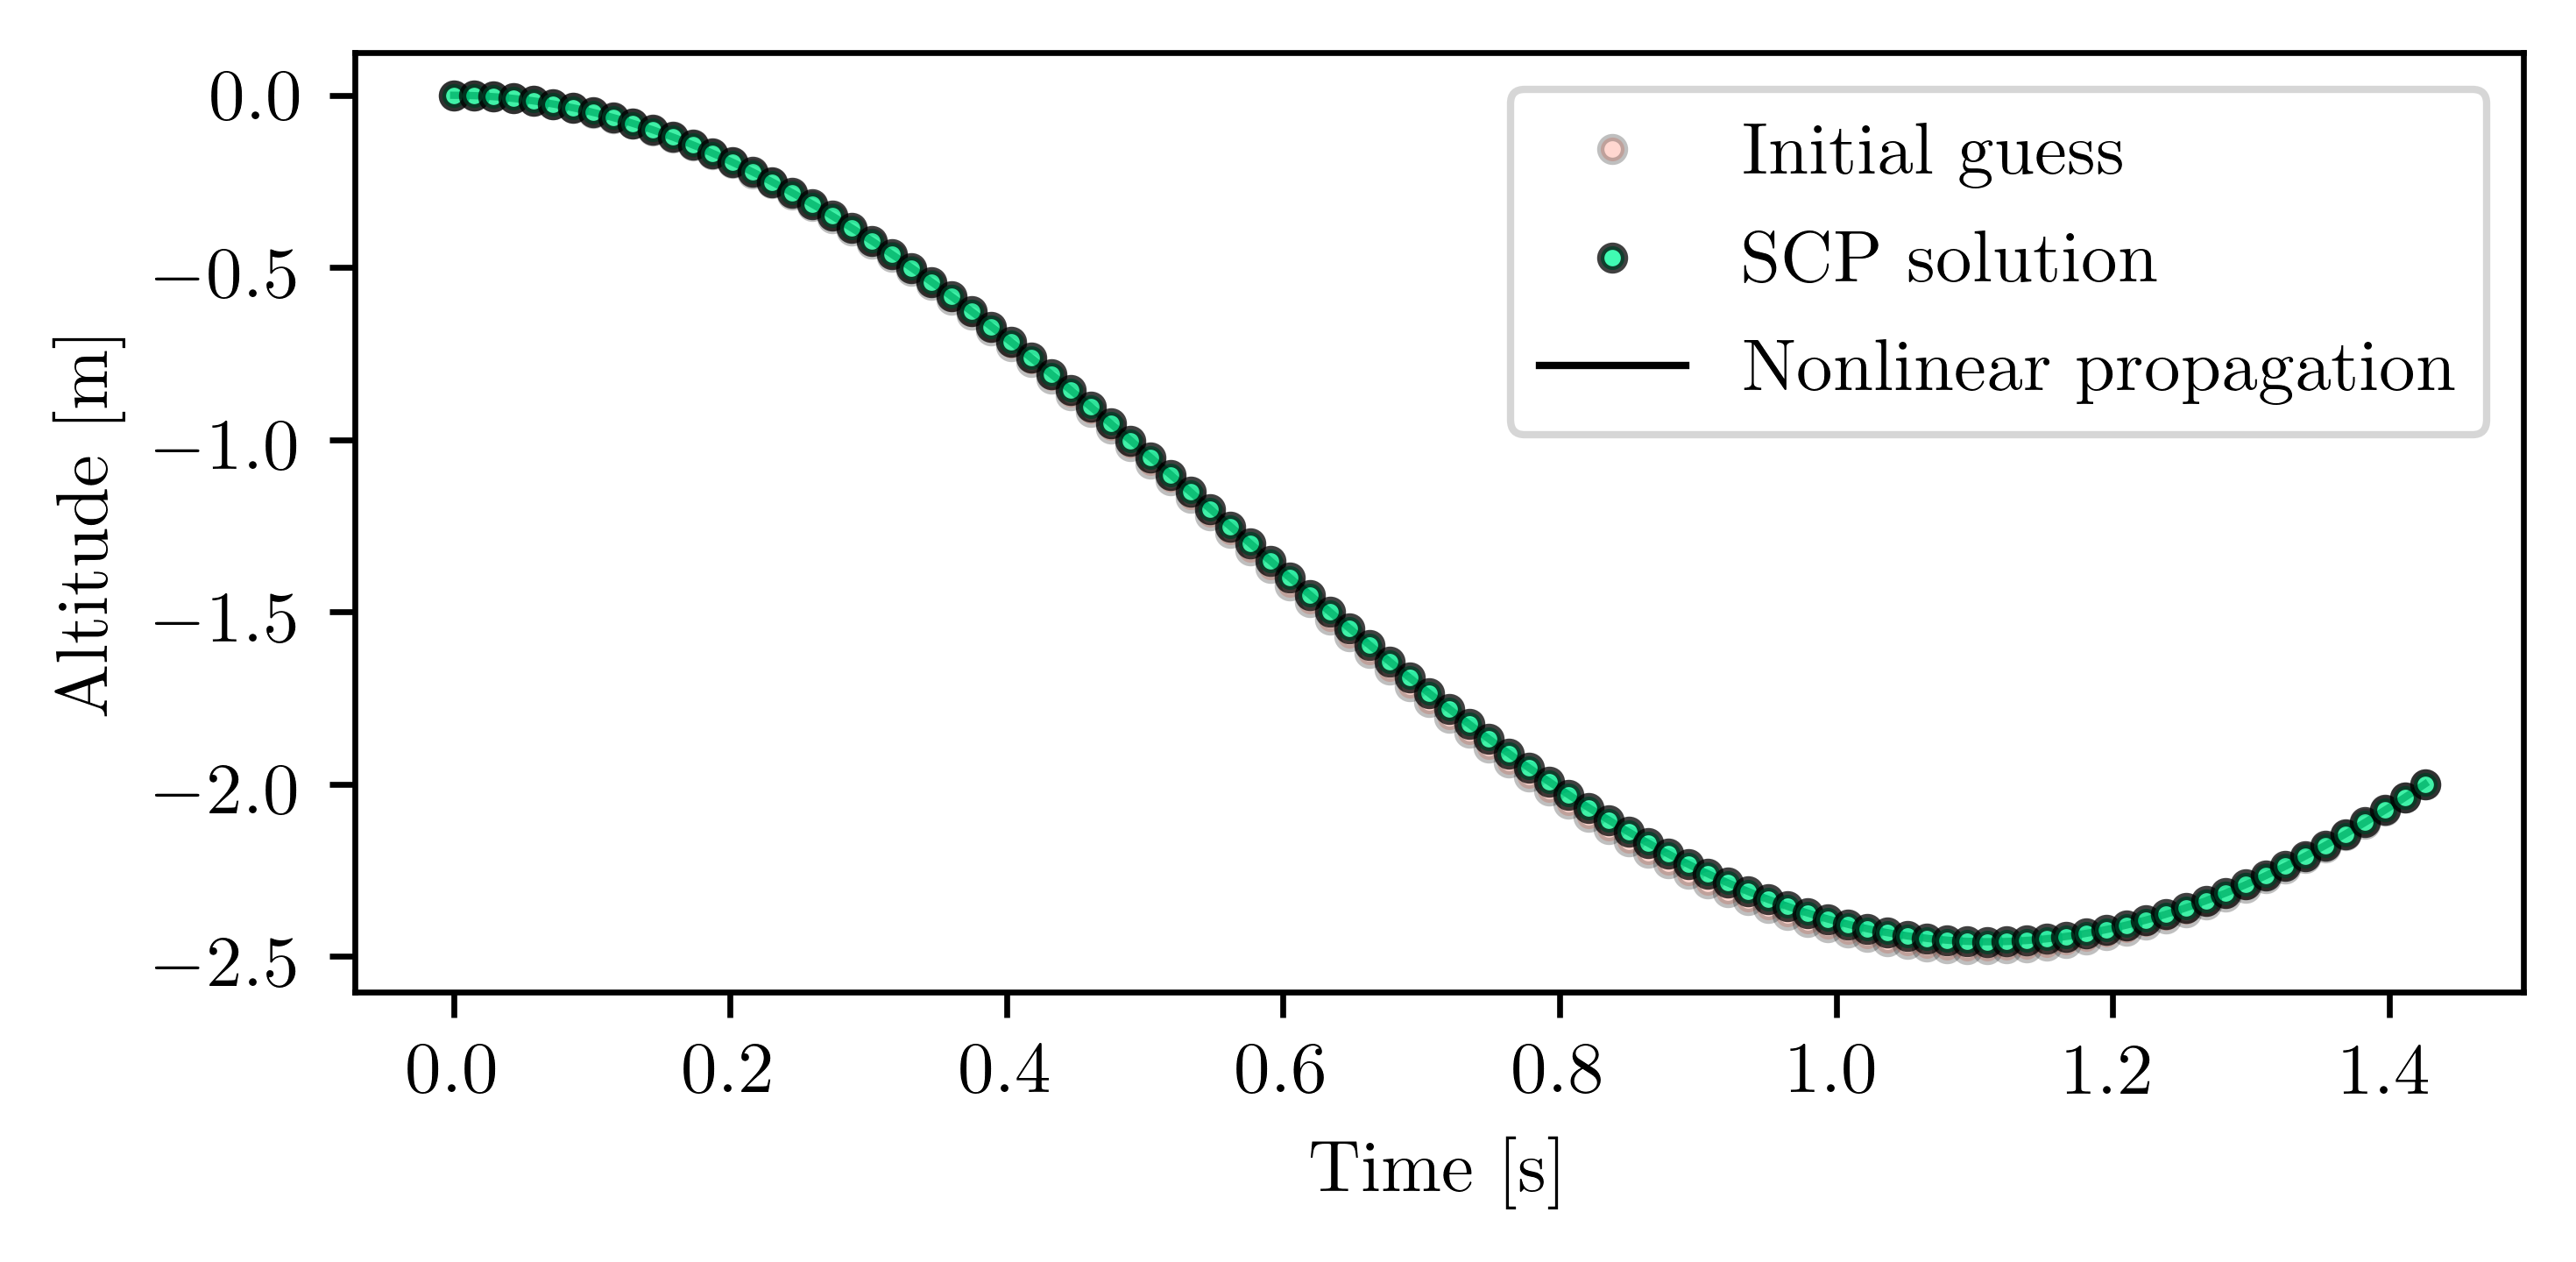

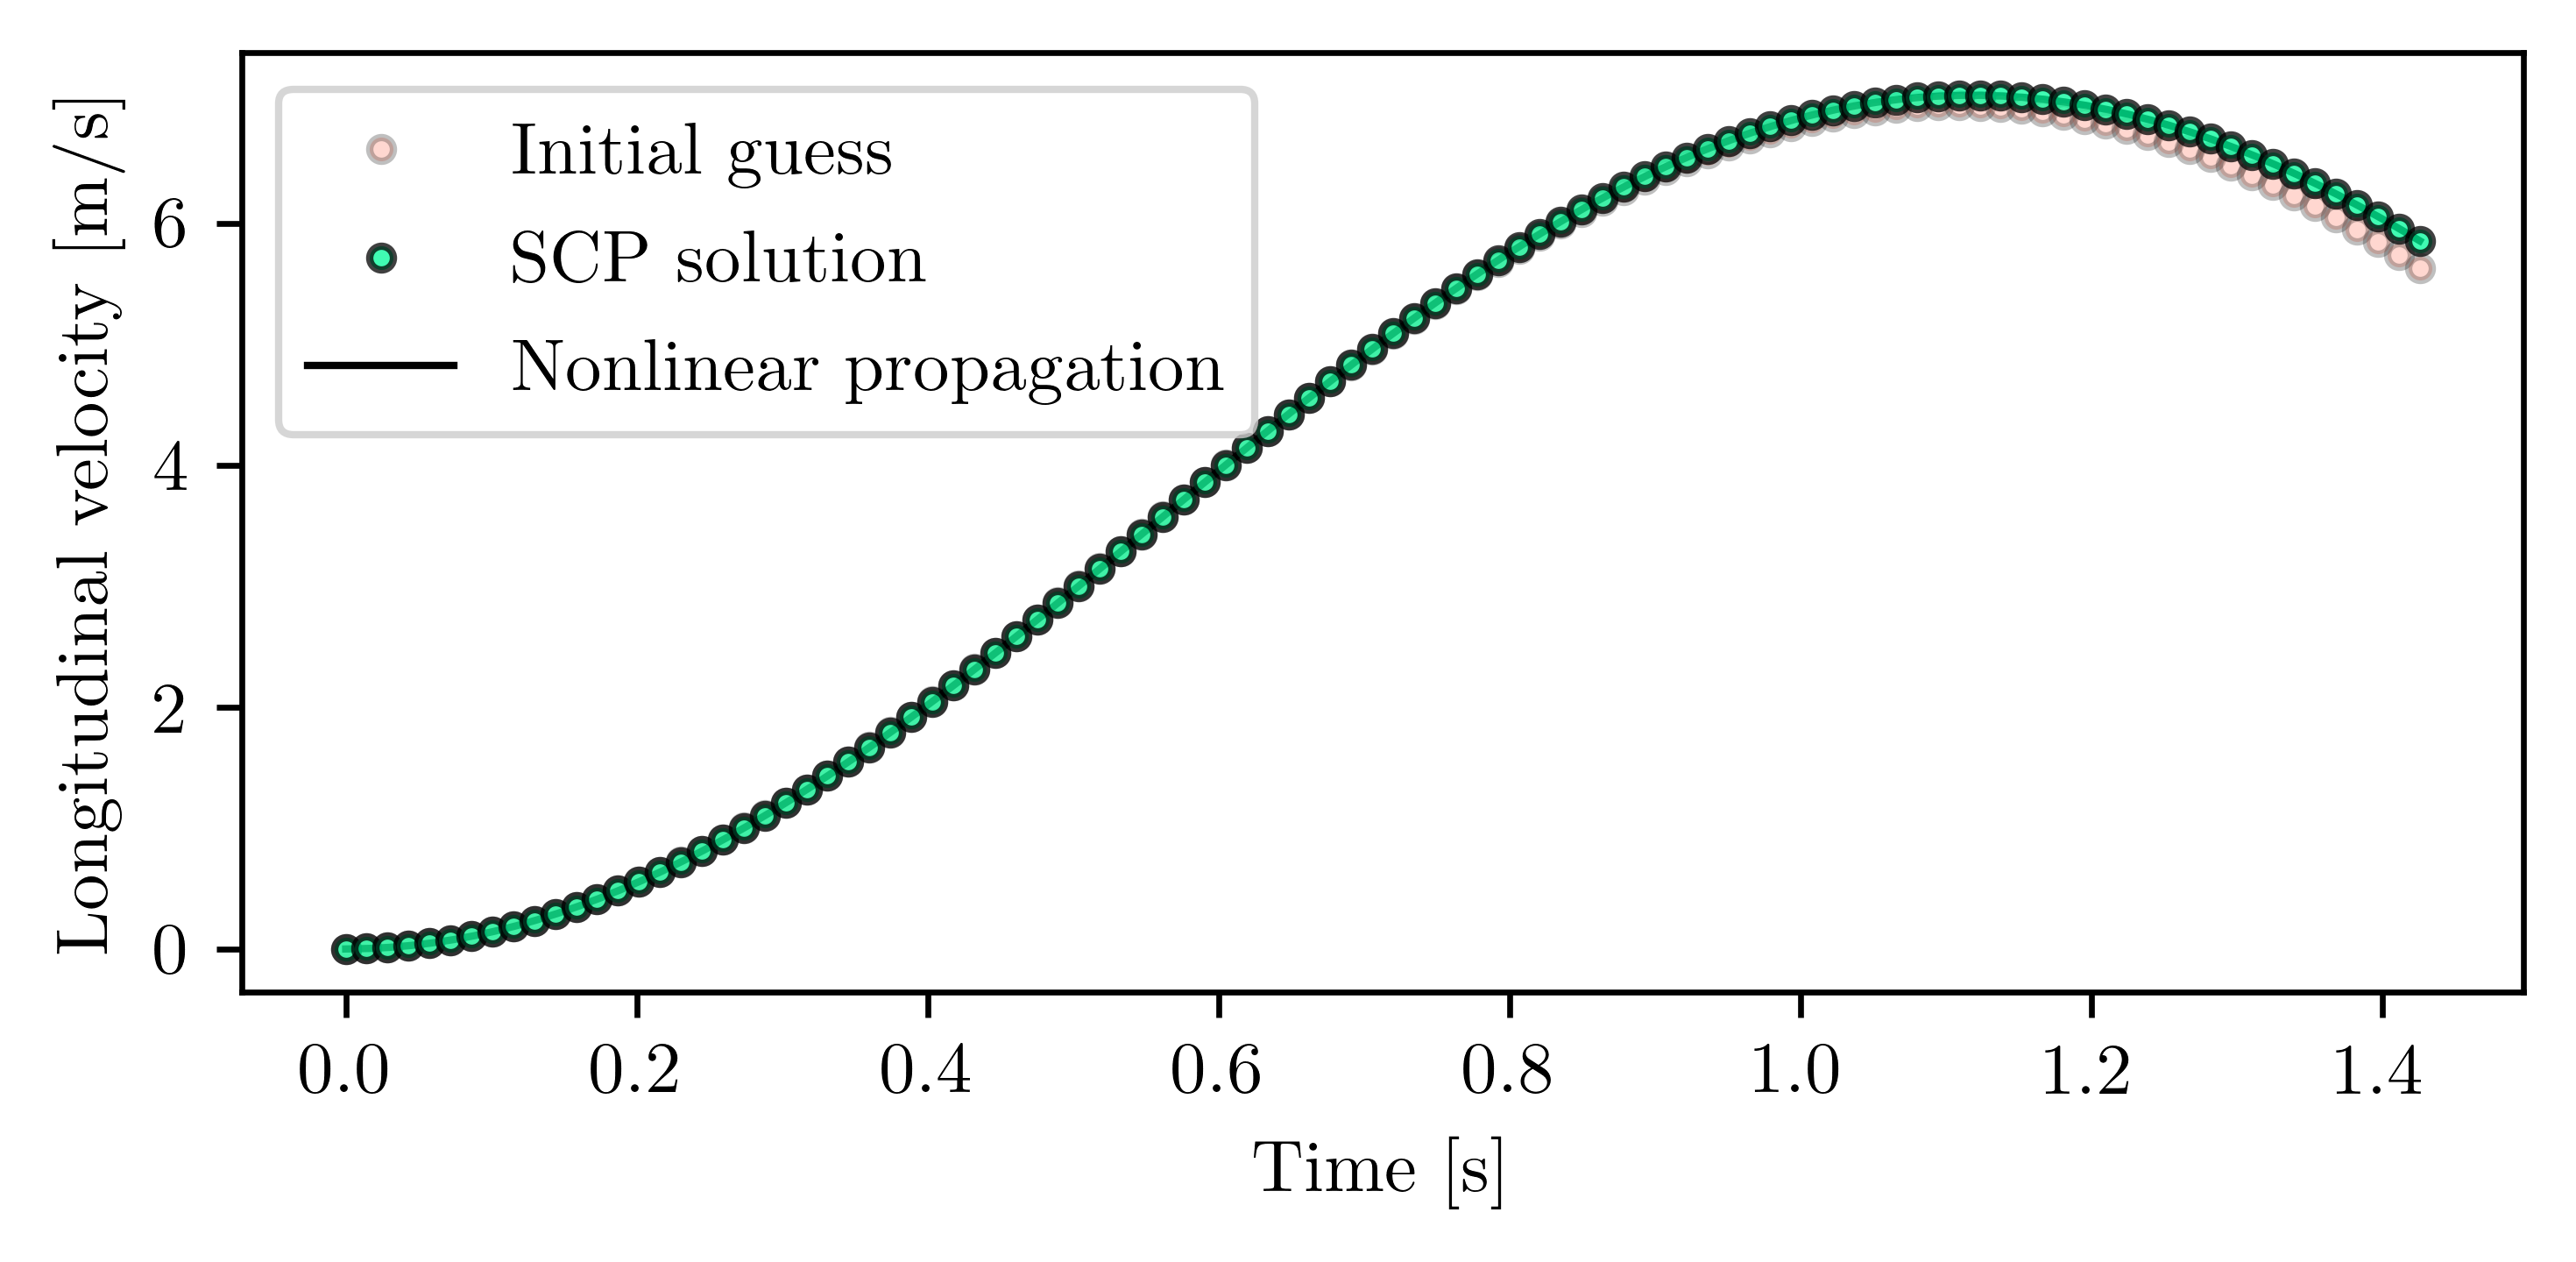

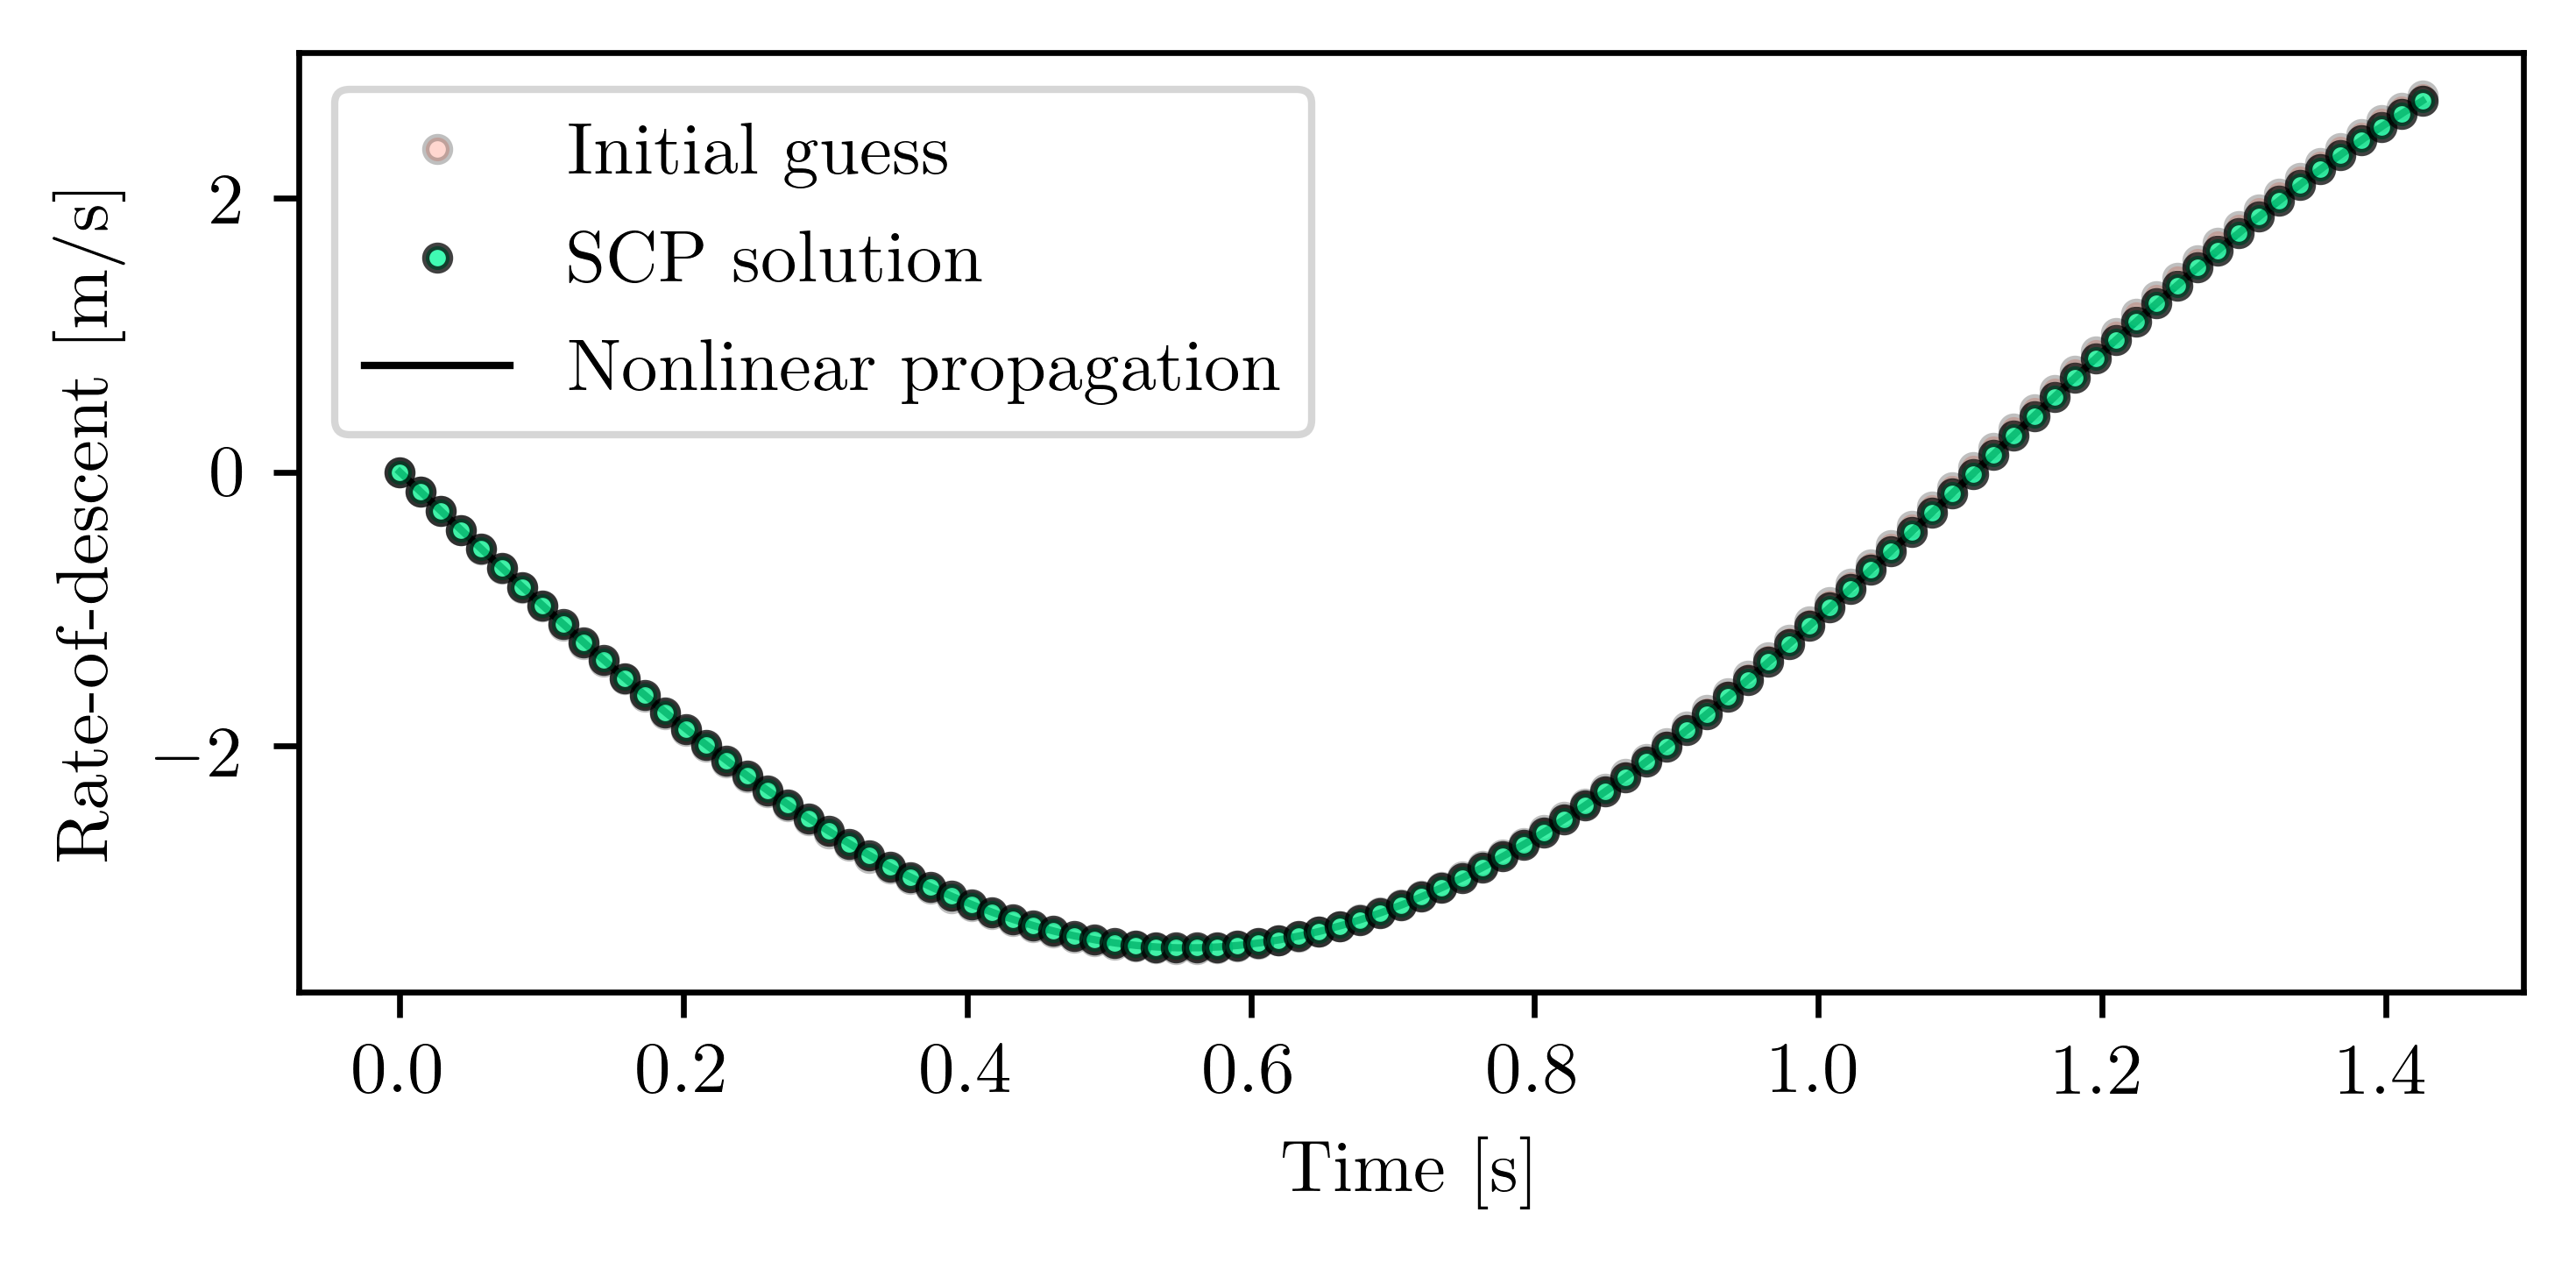

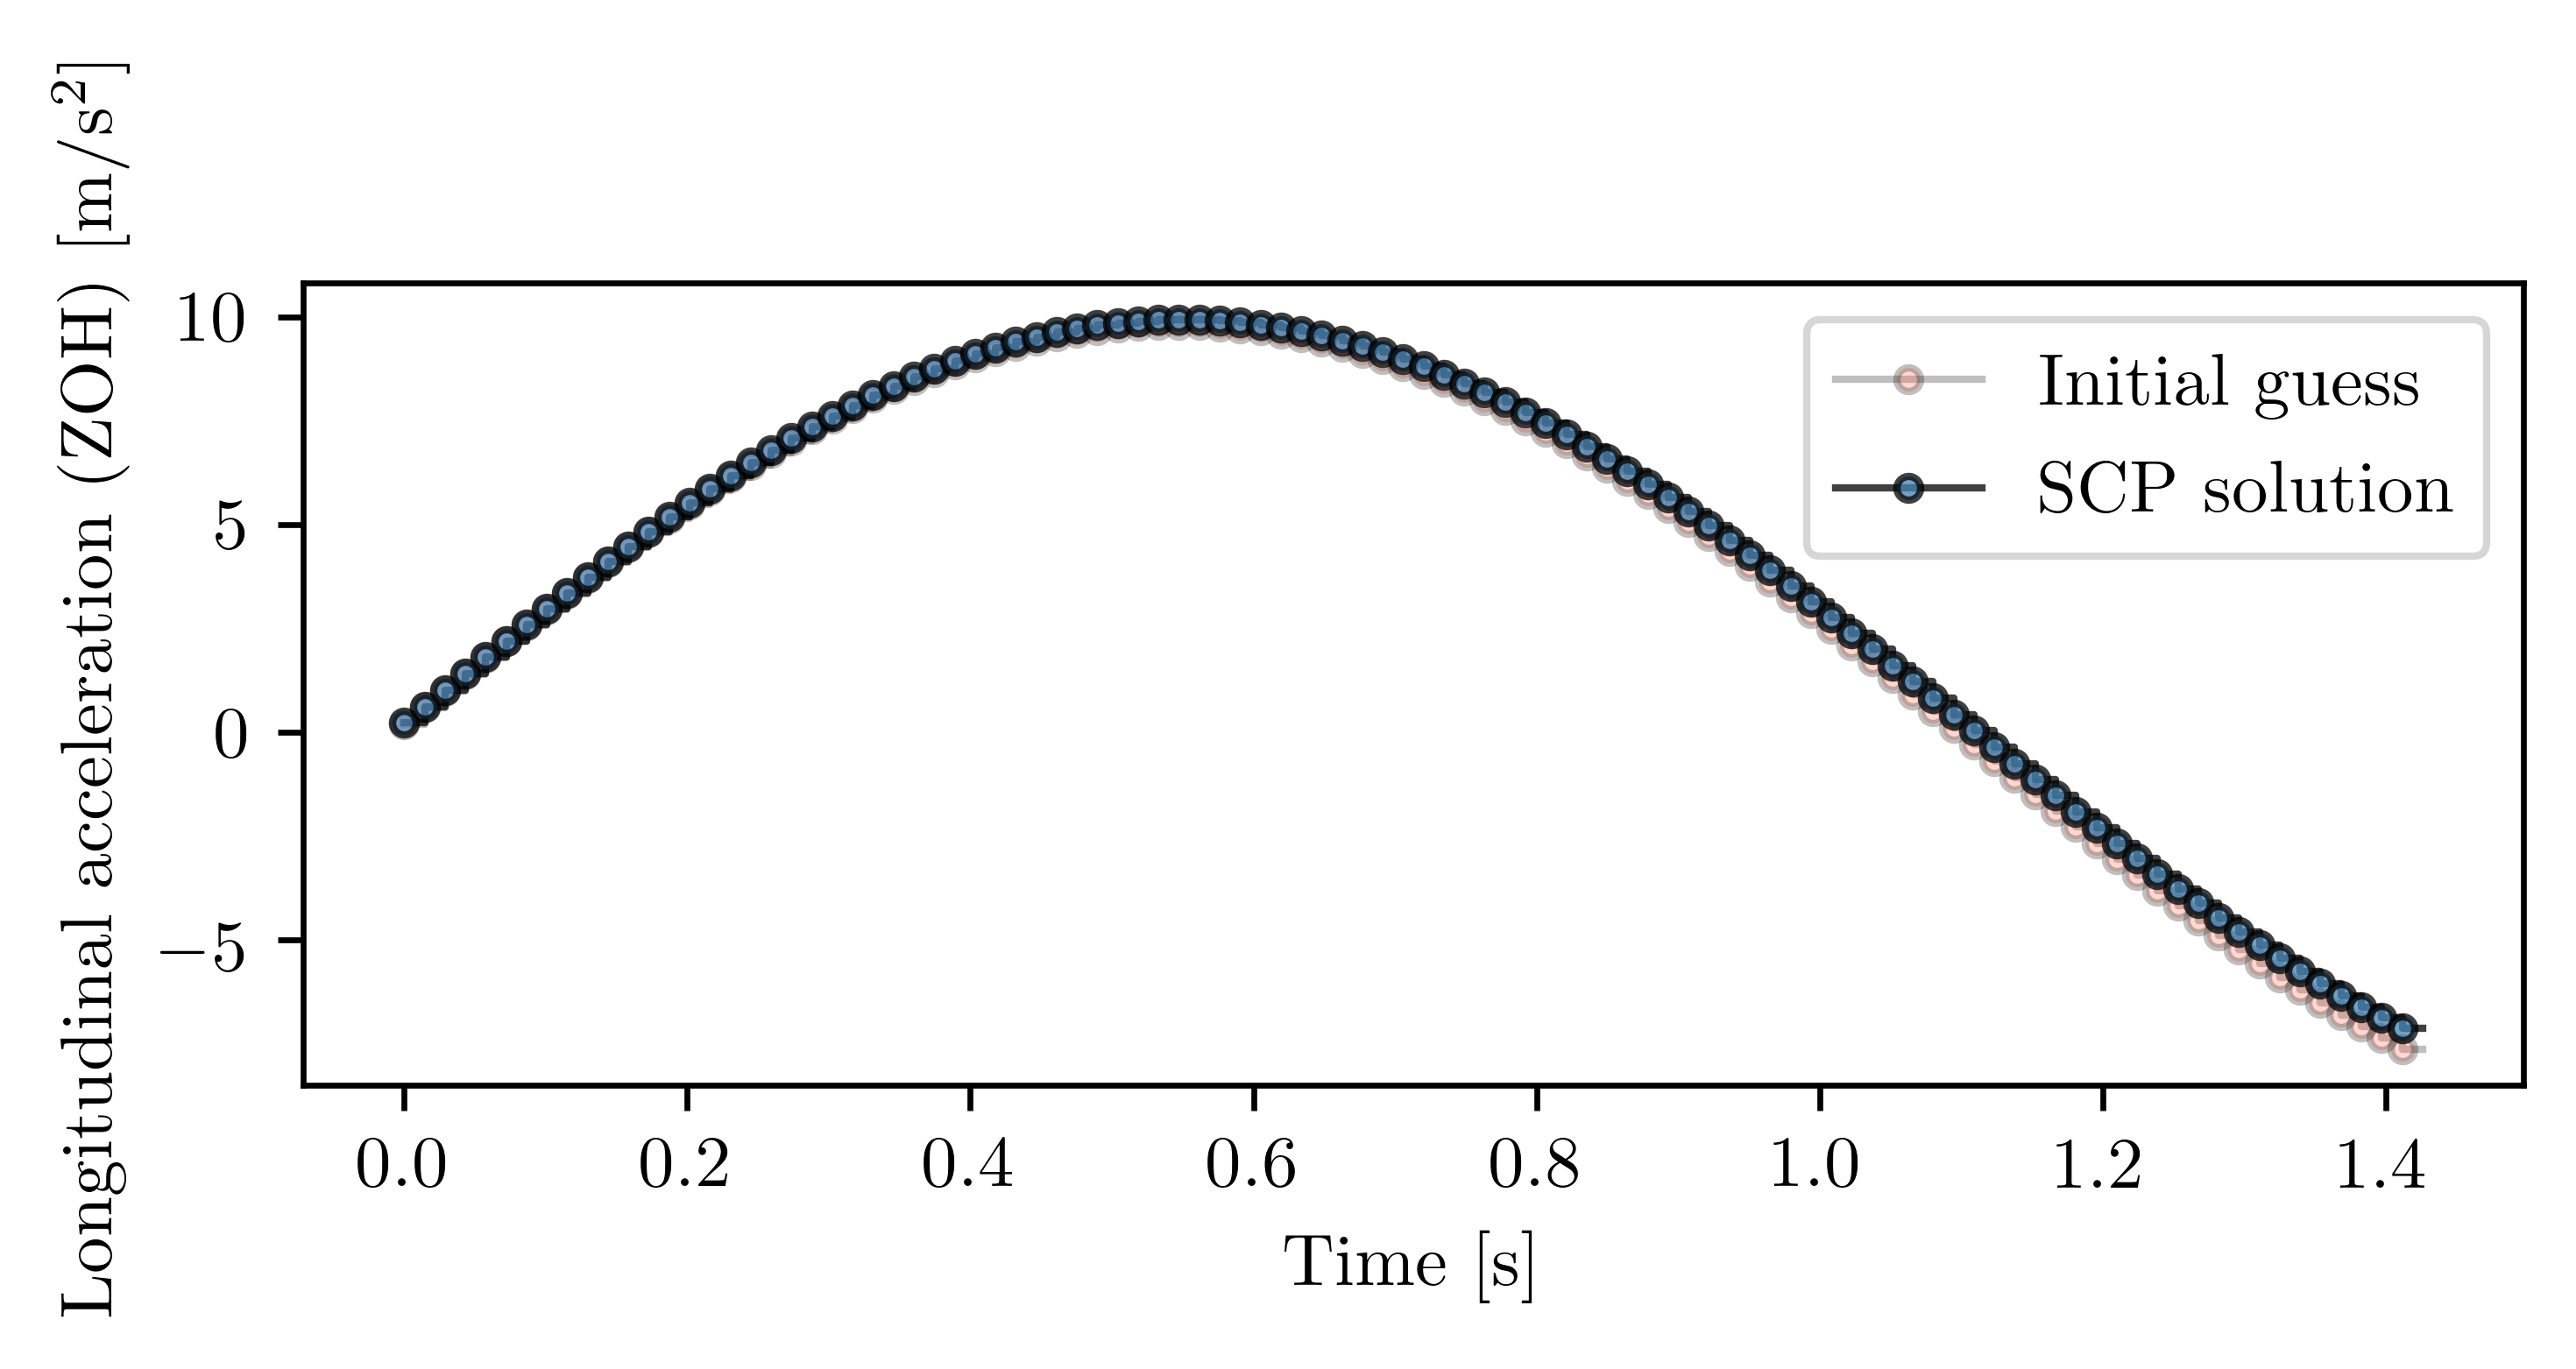

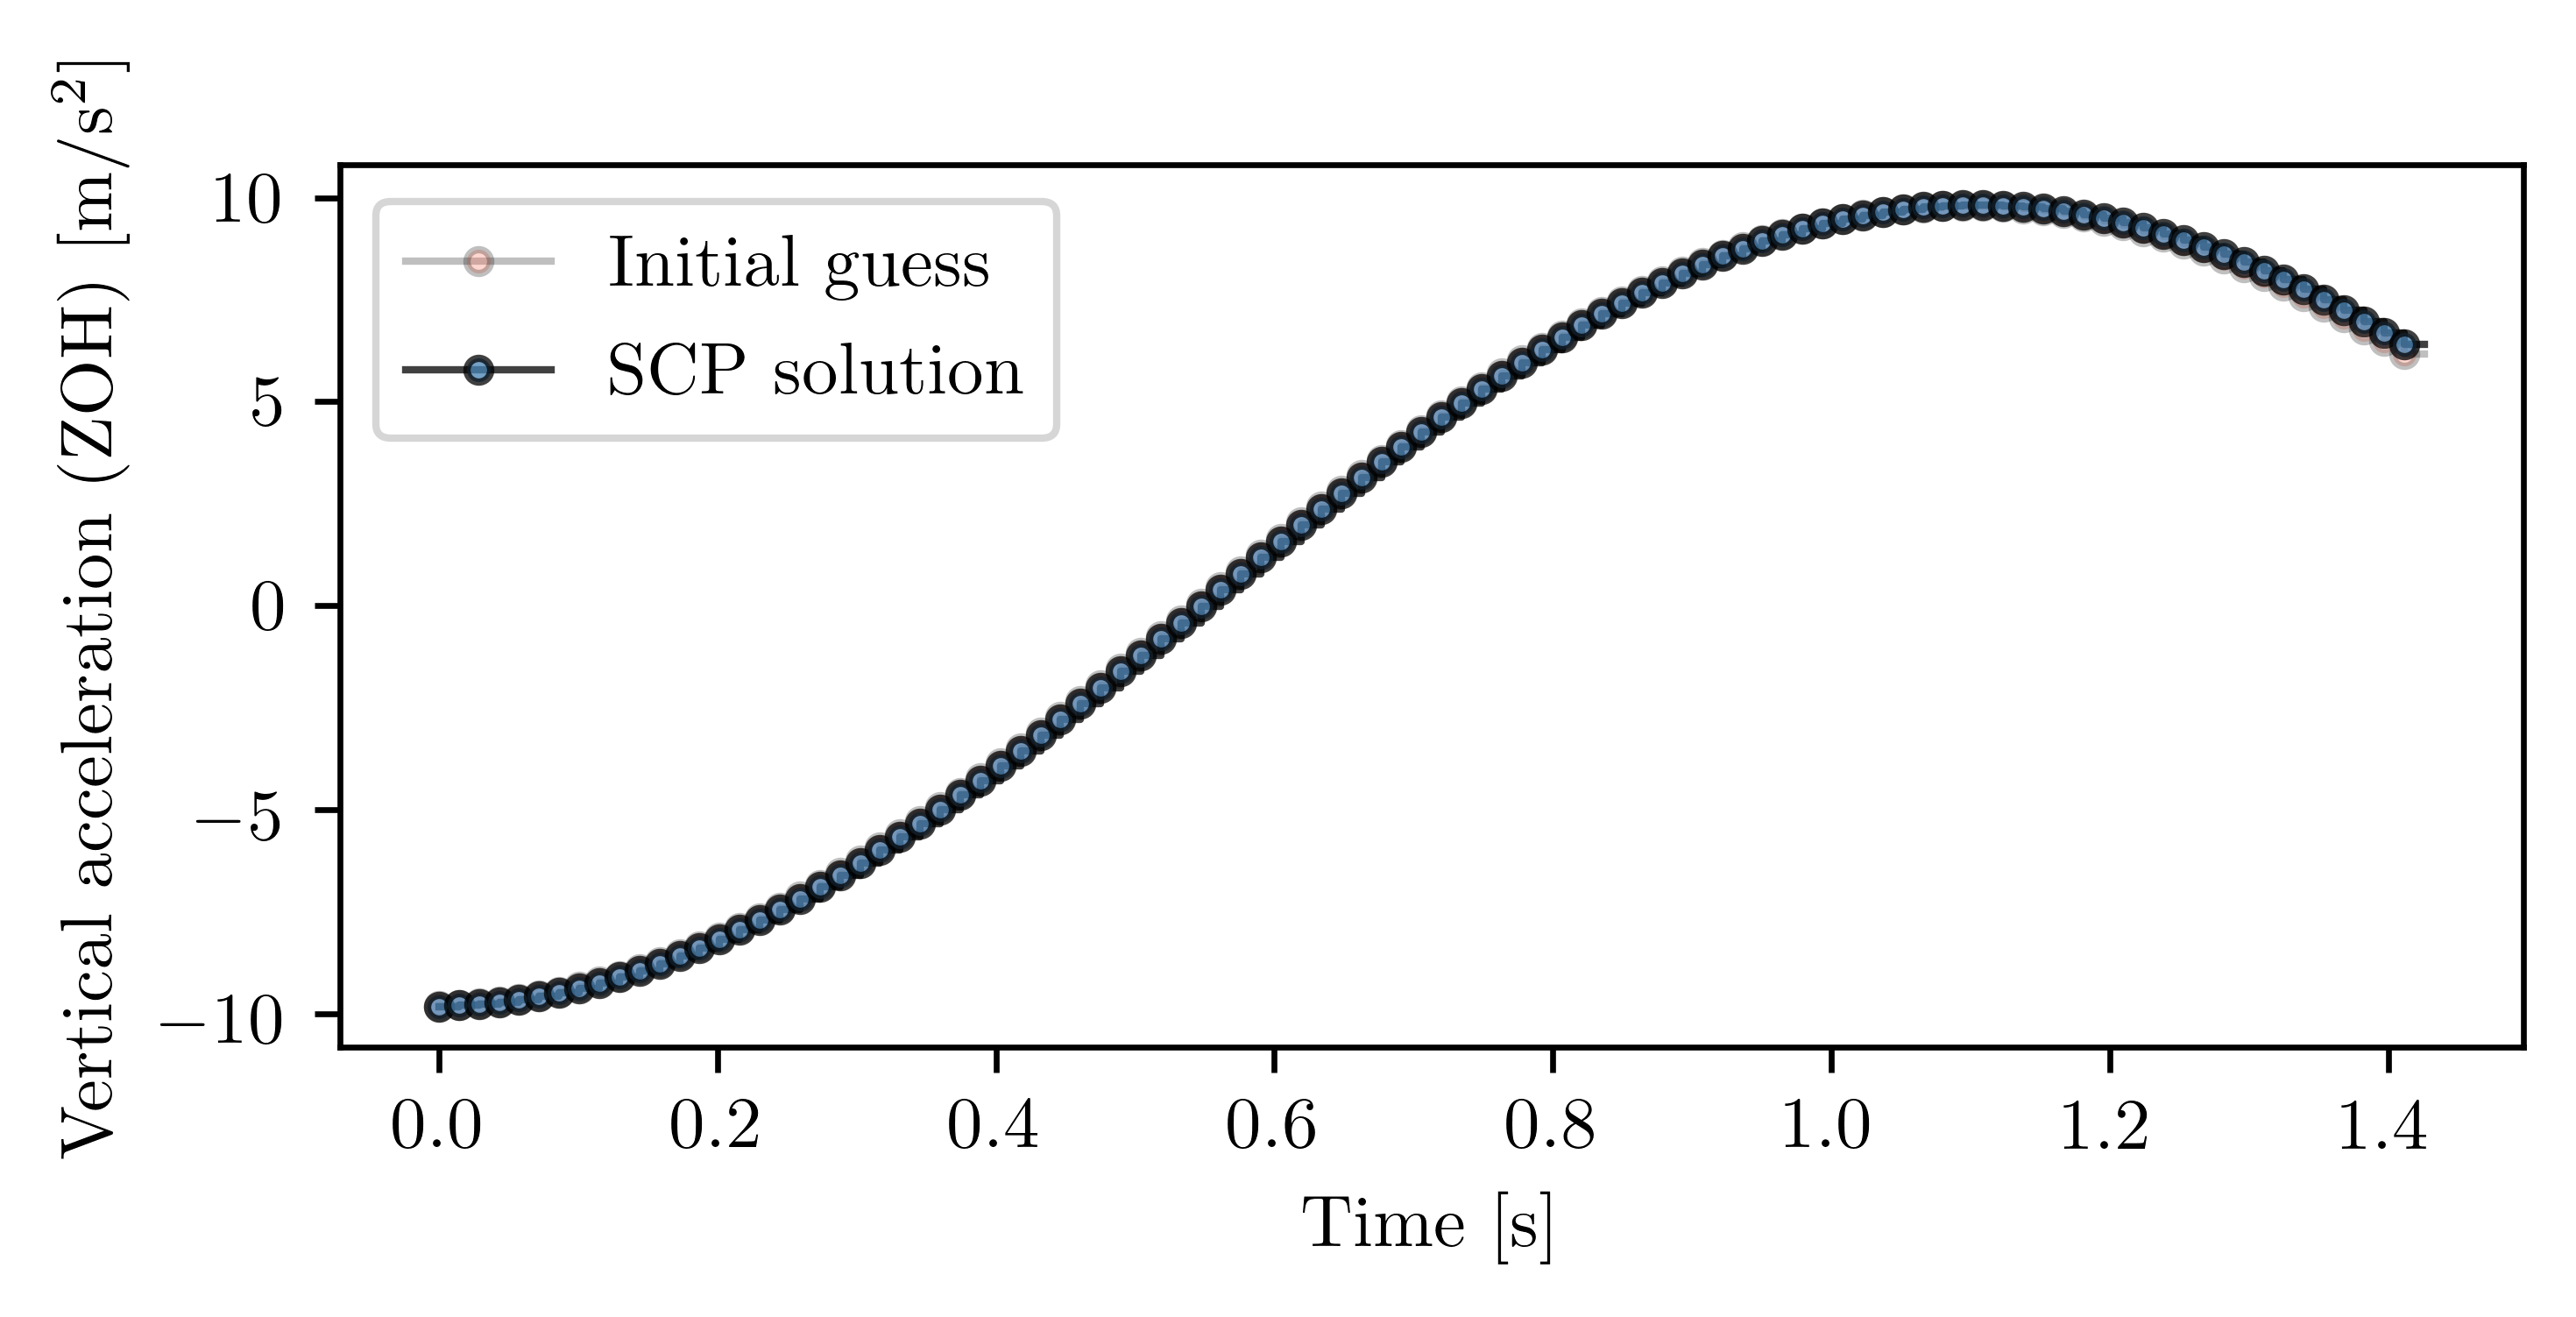

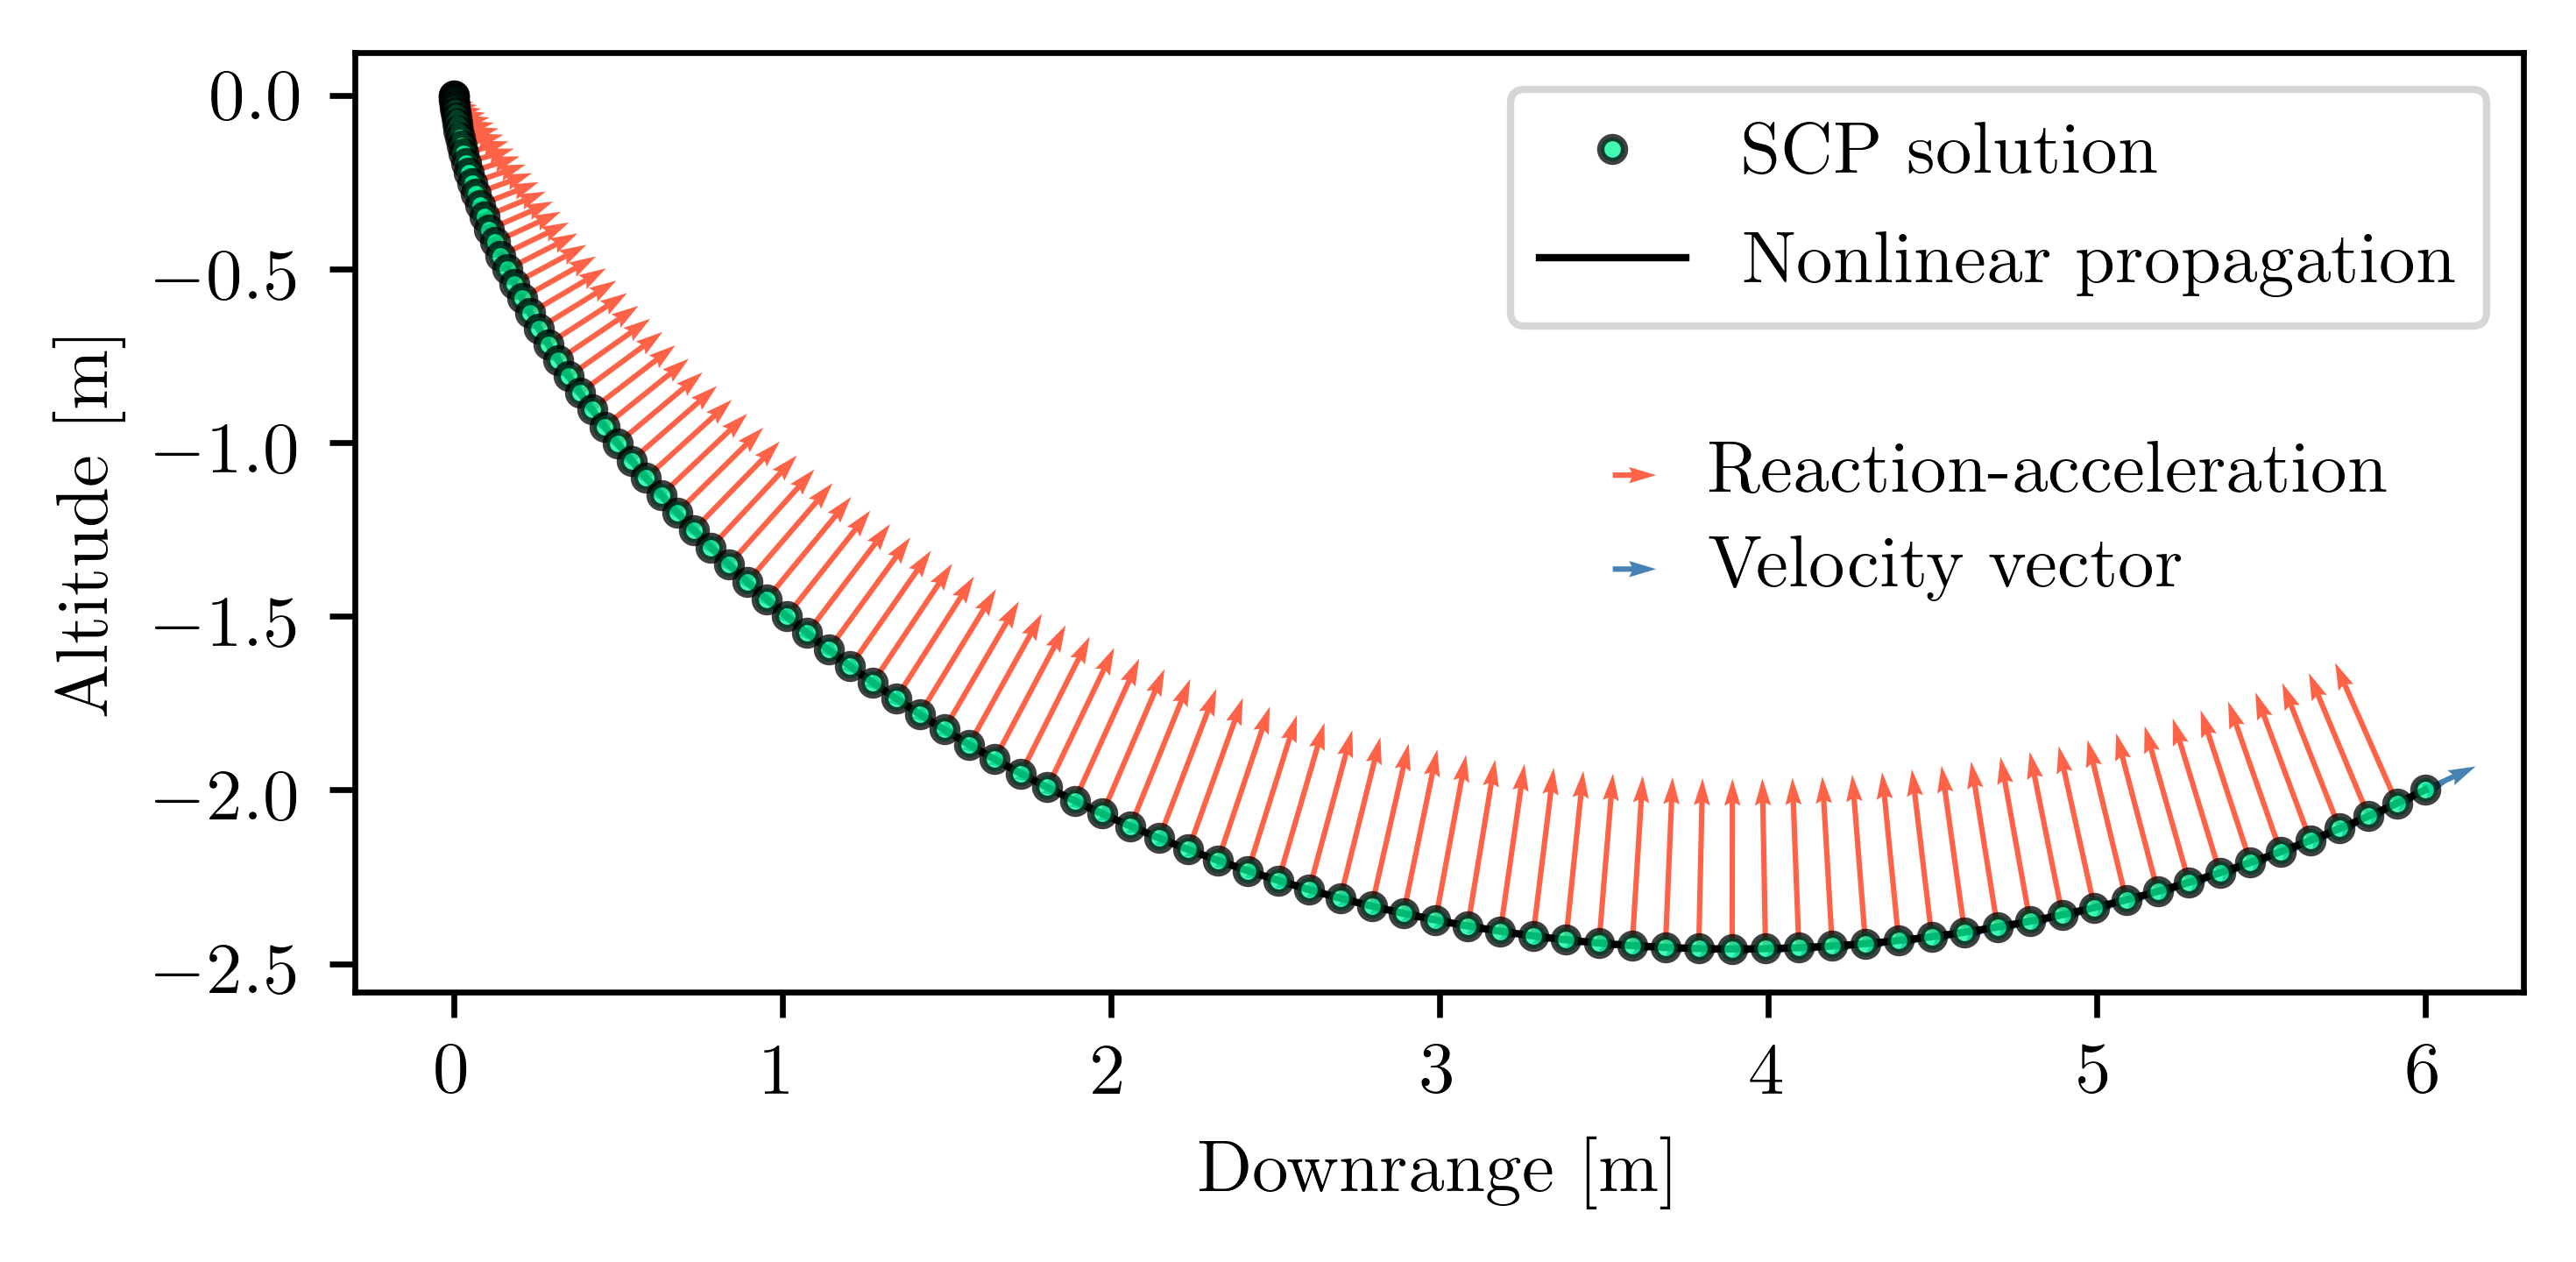

In [31]:
# States

fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = 1
line1 = ax.plot(ts, x[:, 0], linewidth=1, color='k', label='Nonlinear propagation')
line2 = ax.plot(tss, r_init.T[:, 0], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='tomato', alpha=0.25, label='Initial guess')
line3 = ax.plot(tss, r.T[:, 0], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='mediumspringgreen', alpha=0.75, label='SCP solution')
plt.xlabel(r'Time [s]')
plt.ylabel(r'Downrange [m]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = 1
line1 = ax.plot(ts, x[:, 1], linewidth=1, color='k', label='Nonlinear propagation')
line2 = ax.plot(tss, r_init.T[:, 1], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='tomato', alpha=0.25, label='Initial guess')
line3 = ax.plot(tss, r.T[:, 1], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='mediumspringgreen', alpha=0.75, label='SCP solution')
plt.xlabel(r'Time [s]')
plt.ylabel(r'Altitude [m]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = 1
line1 = ax.plot(ts, x[:, 2], linewidth=1, color='k', label='Nonlinear propagation')
line2 = ax.plot(tss, v_init.T[:, 0], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='tomato', alpha=0.25, label='Initial guess')
line3 = ax.plot(tss, v.T[:, 0], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='mediumspringgreen', alpha=0.75, label='SCP solution')
plt.xlabel(r'Time [s]')
plt.ylabel(r'Longitudinal velocity [m/s]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = 1
line1 = ax.plot(ts, x[:, 3], linewidth=1, color='k', label='Nonlinear propagation')
line2 = ax.plot(tss, v_init.T[:, 1], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='tomato', alpha=0.25, label='Initial guess')
line3 = ax.plot(tss, v.T[:, 1], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='mediumspringgreen', alpha=0.75, label='SCP solution')
plt.xlabel(r'Time [s]')
plt.ylabel(r'Rate-of-descent [m/s]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

# Controls

fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = range(0, len(tsu))
line1 = ax.plot(tss, np.hstack((u_init[0], u_init[0][-1])), linewidth=1, drawstyle='steps-post', color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='tomato', alpha=0.25, label='Initial guess')
line2 = ax.plot(tss, np.hstack((u[0], u[0][-1])), linewidth=1, drawstyle='steps-post', color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='steelblue', alpha=0.75, label='SCP solution')
plt.xlabel(r'Time [s]')
plt.ylabel(r'Longitudinal acceleration (ZOH) [m/s$^2$]')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = range(0, len(tsu))
line1 = ax.plot(tss, np.hstack((u_init[1], u_init[1][-1]))-abs(G), linewidth=1, drawstyle='steps-post', color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='tomato', alpha=0.25, label='Initial guess')
line2 = ax.plot(tss, np.hstack((u[1], u[1][-1]))-abs(G), linewidth=1, drawstyle='steps-post', color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='steelblue', alpha=0.75, label='SCP solution')
plt.xlabel(r'Time [s]')
plt.ylabel(r'Vertical acceleration (ZOH) [m/s$^2$]')
plt.legend()
plt.show()

# Trajectory

fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = 1
line1 = ax.plot(x[:, 0], x[:, 1], linewidth=1, color='k', label='Nonlinear propagation')
line2 = ax.plot(r.T[:, 0], r.T[:, 1], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='mediumspringgreen', alpha=0.75, label='SCP solution')
Q1 = ax.quiver(r.T[:-1, 0], r.T[:-1, 1], u[0], u[1], color='tomato', antialiased=True, width=0.0025, scale=250)
Q2 = ax.quiver(r.T[:, 0], r.T[:, 1], r.T[:, 0], r.T[:, 1], color='steelblue', antialiased=True, width=0.0025, scale=250, pivot='tip')
qk1 = ax.quiverkey(Q1, 0.6, 0.55, 5.0, r'Reaction-acceleration', labelpos='E')
qk2 = ax.quiverkey(Q2, 0.6, 0.45, 5.0, r'Position vector', labelpos='E')
plt.xlabel(r'Downrange [m]')
plt.ylabel(r'Altitude [m]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = 1
line1 = ax.plot(x[:, 0], x[:, 1], linewidth=1, color='k', label='Nonlinear propagation')
line2 = ax.plot(r.T[:, 0], r.T[:, 1], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='mediumspringgreen', alpha=0.75, label='SCP solution')
Q1 = ax.quiver(r.T[:-1, 0], r.T[:-1, 1], u[0], u[1], color='tomato', antialiased=True, width=0.0025, scale=250)
Q2 = ax.quiver(r.T[:, 0], r.T[:, 1], v.T[:, 0], v.T[:, 1], color='steelblue', antialiased=True, width=0.0025, scale=250)
qk1 = ax.quiverkey(Q1, 0.6, 0.55, 5.0, r'Reaction-acceleration', labelpos='E')
qk2 = ax.quiverkey(Q2, 0.6, 0.45, 5.0, r'Velocity vector', labelpos='E')
plt.xlabel(r'Downrange [m]')
plt.ylabel(r'Altitude [m]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

# fig.savefig("plots/slide.pdf", format="pdf", bbox_inches = 'tight')

fig, ax = plt.subplots(figsize=(5, 2.5))
markevery = 1
line1 = ax.plot(x[:, 0], x[:, 1], linewidth=1, color='k', label='Nonlinear propagation')
line2 = ax.plot(r_cyc[:, 0], -r_cyc[:, 1], linewidth=1, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='steelblue', alpha=0.75, label='Analytical solution')
line3 = ax.plot(r_init.T[:, 0], r_init.T[:, 1], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='tomato', alpha=0.25, label='Initial guess')
line4 = ax.plot(r.T[:, 0], r.T[:, 1], linewidth=0, color='k', marker='o', markevery=markevery, ms=3.25, markerfacecolor='mediumspringgreen', alpha=0.75, label='SCP solution')
plt.xlabel(r'Downrange [m]')
plt.ylabel(r'Altitude [m]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

# fig.savefig("plots/compare.pdf", format="pdf", bbox_inches = 'tight')

### Constraint violation checks

In [32]:
np.sqrt(np.mean((la.norm(u+np.c_[g], axis=0) - la.norm(g))**2)) # ~0

In [33]:
max([abs(u[:, i].T@v[:, i]) for i in range(N-1)]) # ~0